In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# #############################################################################

print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Load LMI data
print("Loading LMI data...")
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group information
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

# Load classifier weights
print("Loading classifier weights...")
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

# Merge datasets on mouse_id and roi
print("Merging datasets...")
data = lmi_df.merge(weights_df[['mouse_id', 'roi', 'classifier_weight', 'classifier_weight_raw']],
                    on=['mouse_id', 'roi'], how='inner')

# Define cell type groups
# non-projectors are cells with NaN in cell_type column
data['cell_type_group'] = data['cell_type'].copy()
data.loc[data['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
data.loc[data['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
data.loc[data['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'

# Keep only the three groups we're interested in
data = data[data['cell_type_group'].isin(['non_projector', 'wS2', 'wM1'])]

print(f"Total cells after merge: {len(data)}")
print(f"Cell type distribution:\n{data['cell_type_group'].value_counts()}")
print(f"Reward group distribution:\n{data['reward_group'].value_counts()}")

# Define criteria globally across all mice
print("\nDefining criteria thresholds...")

# LMI criteria
data['positive_lmi'] = data['lmi_p'] >= 0.975
data['negative_lmi'] = data['lmi_p'] <= 0.025

# Top percentiles for absolute LMI
abs_lmi = np.abs(data['lmi'])
data['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
data['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
data['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Classifier weight criteria - separate by sign
pos_weights = data[data['classifier_weight'] > 0]['classifier_weight']
neg_weights = data[data['classifier_weight'] < 0]['classifier_weight']

data['top_1pct_pos_weight'] = False
data['top_5pct_pos_weight'] = False
data['top_10pct_pos_weight'] = False
data['top_1pct_neg_weight'] = False
data['top_5pct_neg_weight'] = False
data['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    data.loc[data['classifier_weight'] > 0, 'top_1pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    data.loc[data['classifier_weight'] > 0, 'top_5pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    data.loc[data['classifier_weight'] > 0, 'top_10pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    data.loc[data['classifier_weight'] < 0, 'top_1pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    data.loc[data['classifier_weight'] < 0, 'top_5pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    data.loc[data['classifier_weight'] < 0, 'top_10pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

print(f"Positive LMI cells: {data['positive_lmi'].sum()}")
print(f"Negative LMI cells: {data['negative_lmi'].sum()}")
print(f"Top 1% abs LMI: {data['top_1pct_abs_lmi'].sum()}")
print(f"Top 1% positive weights: {data['top_1pct_pos_weight'].sum()}")
print(f"Top 1% negative weights: {data['top_1pct_neg_weight'].sum()}")

# Define all criteria to analyze
criteria = [
    'positive_lmi', 'negative_lmi',
    'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi',
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]

cell_types = ['non_projector', 'wS2', 'wM1']

# Compute proportions and chi-square tests for each reward group separately
print("\nComputing proportions and statistical tests...")

proportions_results = []
chi_square_results = []

for reward_group in ['R+', 'R-']:
    data_rg = data[data['reward_group'] == reward_group]

    print(f"\n{reward_group} Group: {len(data_rg)} cells")

    for criterion in criteria:
        # Create contingency table: rows=cell_type, columns=criterion (met/not met)
        contingency = pd.crosstab(data_rg['cell_type_group'], data_rg[criterion])

        # Ensure both True and False columns exist
        for col in [False, True]:
            if col not in contingency.columns:
                contingency[col] = 0

        # Reorder columns
        contingency = contingency[[False, True]]

        # Calculate proportions for each cell type
        for cell_type in cell_types:
            if cell_type in contingency.index:
                total = contingency.loc[cell_type, :].sum()
                met = contingency.loc[cell_type, True]
                proportion = met / total if total > 0 else 0

                proportions_results.append({
                    'reward_group': reward_group,
                    'cell_type': cell_type,
                    'criterion': criterion,
                    'n_total': int(total),
                    'n_met': int(met),
                    'proportion': proportion
                })

        # Perform chi-square test
        if len(contingency) >= 2 and contingency.shape[1] >= 2:
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': chi2,
                    'p_value': p_value,
                    'dof': dof
                })

                # Print significant results
                if p_value < 0.05:
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} ***")
            except Exception as e:
                print(f"  {criterion}: Chi-square test failed - {e}")
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': np.nan,
                    'p_value': np.nan,
                    'dof': np.nan
                })

# Convert to DataFrames
df_proportions = pd.DataFrame(proportions_results)
df_chi_square = pd.DataFrame(chi_square_results)

# Save results
print("\nSaving results...")
df_proportions.to_csv(os.path.join(output_dir, 'proportions_summary.csv'), index=False)
df_chi_square.to_csv(os.path.join(output_dir, 'chi_square_results.csv'), index=False)

print(f"Saved proportions_summary.csv")
print(f"Saved chi_square_results.csv")

# Create visualizations
print("\nCreating visualizations...")

# Define colors for cell types
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# Figure 1: LMI Proportions
# ==========================
print("  Creating LMI proportions figure...")

lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2))

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_lmi_proportions.svg")

# Figure 2: Classifier Weight Proportions
# ========================================
print("  Creating classifier weight proportions figure...")

weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_labels = [
    'Top 1%\nPos Weight', 'Top 5%\nPos Weight', 'Top 10%\nPos Weight',
    'Top 1%\nNeg Weight', 'Top 5%\nNeg Weight', 'Top 10%\nNeg Weight'
]

fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_weight_proportions.svg")

# Figure 3: Summary Heatmap
# =========================
print("  Creating summary heatmap...")

# Create pivot table for heatmap
heatmap_data = []
for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        row_data = {'reward_group': reward_group, 'cell_type': cell_type}
        for criterion in criteria:
            prop_val = df_proportions[
                (df_proportions['reward_group'] == reward_group) &
                (df_proportions['cell_type'] == cell_type) &
                (df_proportions['criterion'] == criterion)
            ]['proportion'].values
            row_data[criterion] = prop_val[0] if len(prop_val) > 0 else 0
        heatmap_data.append(row_data)

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap['group_label'] = df_heatmap['reward_group'] + ' ' + df_heatmap['cell_type']

# Create heatmap matrix
heatmap_matrix = df_heatmap[criteria].values

fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# Set ticks and labels
ax.set_xticks(np.arange(len(criteria)))
ax.set_yticks(np.arange(len(df_heatmap)))

criterion_labels = [
    'Pos LMI', 'Neg LMI',
    'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI',
    'Top 1%\npos wt', 'Top 5%\npos wt', 'Top 10%\npos wt',
    'Top 1%\nneg wt', 'Top 5%\nneg wt', 'Top 10%\nneg wt'
]

ax.set_xticklabels(criterion_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heatmap['group_label'].values, fontsize=10)

# Add text annotations
for i in range(len(df_heatmap)):
    for j in range(len(criteria)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion', rotation=270, labelpad=20, fontsize=12)

# Add title
ax.set_title('Proportion of Cell Types Meeting Each Criterion', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(criteria))-.5, minor=True)
ax.set_yticks(np.arange(len(df_heatmap))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_summary_heatmap.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_summary_heatmap.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80 + "\n")
print(f"All outputs saved to: {output_dir}")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS



NameError: name 'io' is not defined

In [ ]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
from scipy.stats import mannwhitneyu, wilcoxon, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from matplotlib.backends.backend_pdf import PdfPages
import xarray as xr

# sys.path.append(r'H:/anthony/repos/NWB_analysis')
sys.path.append(r'/home/aprenard/repos/NWB_analysis')
sys.path.append(r'/home/aprenard/repos/fast-learning')
# from nwb_wrappers import nwb_reader_functions as nwb_read
import src.utils.utils_imaging as imaging_utils 
import src.utils.utils_io as io
from src.utils.utils_plot import *
from scipy.stats import ks_2samp
from matplotlib_venn import venn3
import colorsys
from matplotlib import colors as mcolors


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS

Loading LMI data...
Loading classifier weights...
Merging datasets...
Total cells after merge: 1578
Cell type distribution:
cell_type_group
wS2    890
wM1    688
Name: count, dtype: int64
Reward group distribution:
reward_group
R+    1142
R-     436
Name: count, dtype: int64

Defining criteria thresholds...
Positive LMI cells: 317
Negative LMI cells: 253
Top 1% abs LMI: 16
Top 1% positive weights: 8
Top 1% negative weights: 9

Computing proportions and statistical tests...

R+ Group: 1142 cells

R- Group: 436 cells

Saving results...
Saved proportions_summary.csv
Saved chi_square_results.csv

Creating visualizations...
  Creating LMI proportions figure...


KeyError: 'reward_group'

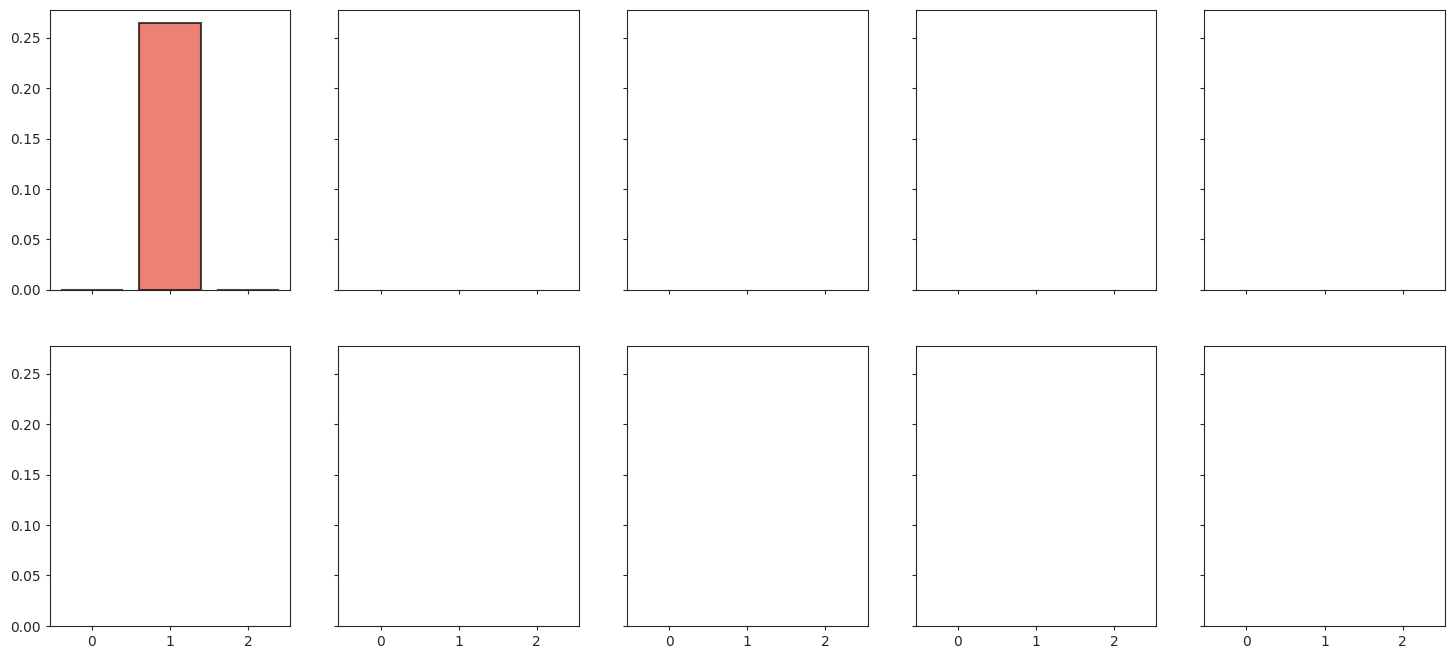

In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# #############################################################################

print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Load LMI data
print("Loading LMI data...")
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group information
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

# Load classifier weights
print("Loading classifier weights...")
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

# Merge datasets on mouse_id and roi
print("Merging datasets...")
data = lmi_df.merge(weights_df[['mouse_id', 'roi', 'classifier_weight', 'classifier_weight_raw']],
                    on=['mouse_id', 'roi'], how='inner')

# Define cell type groups
# non-projectors are cells with NaN in cell_type column
data['cell_type_group'] = data['cell_type'].copy()
data.loc[data['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
data.loc[data['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
data.loc[data['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'

# Keep only the three groups we're interested in
data = data[data['cell_type_group'].isin(['non_projector', 'wS2', 'wM1'])]

print(f"Total cells after merge: {len(data)}")
print(f"Cell type distribution:\n{data['cell_type_group'].value_counts()}")
print(f"Reward group distribution:\n{data['reward_group'].value_counts()}")

# Define criteria globally across all mice
print("\nDefining criteria thresholds...")

# LMI criteria
data['positive_lmi'] = data['lmi_p'] >= 0.975
data['negative_lmi'] = data['lmi_p'] <= 0.025

# Top percentiles for absolute LMI
abs_lmi = np.abs(data['lmi'])
data['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
data['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
data['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Classifier weight criteria - separate by sign
pos_weights = data[data['classifier_weight'] > 0]['classifier_weight']
neg_weights = data[data['classifier_weight'] < 0]['classifier_weight']

data['top_1pct_pos_weight'] = False
data['top_5pct_pos_weight'] = False
data['top_10pct_pos_weight'] = False
data['top_1pct_neg_weight'] = False
data['top_5pct_neg_weight'] = False
data['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    data.loc[data['classifier_weight'] > 0, 'top_1pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    data.loc[data['classifier_weight'] > 0, 'top_5pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    data.loc[data['classifier_weight'] > 0, 'top_10pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    data.loc[data['classifier_weight'] < 0, 'top_1pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    data.loc[data['classifier_weight'] < 0, 'top_5pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    data.loc[data['classifier_weight'] < 0, 'top_10pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

print(f"Positive LMI cells: {data['positive_lmi'].sum()}")
print(f"Negative LMI cells: {data['negative_lmi'].sum()}")
print(f"Top 1% abs LMI: {data['top_1pct_abs_lmi'].sum()}")
print(f"Top 1% positive weights: {data['top_1pct_pos_weight'].sum()}")
print(f"Top 1% negative weights: {data['top_1pct_neg_weight'].sum()}")

# Define all criteria to analyze
criteria = [
    'positive_lmi', 'negative_lmi',
    'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi',
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]

cell_types = ['non_projector', 'wS2', 'wM1']

# Compute proportions and chi-square tests for each reward group separately
print("\nComputing proportions and statistical tests...")

proportions_results = []
chi_square_results = []

for reward_group in ['R+', 'R-']:
    data_rg = data[data['reward_group'] == reward_group]

    print(f"\n{reward_group} Group: {len(data_rg)} cells")

    for criterion in criteria:
        # Create contingency table: rows=cell_type, columns=criterion (met/not met)
        contingency = pd.crosstab(data_rg['cell_type_group'], data_rg[criterion])

        # Ensure both True and False columns exist
        for col in [False, True]:
            if col not in contingency.columns:
                contingency[col] = 0

        # Reorder columns
        contingency = contingency[[False, True]]

        # Calculate proportions for each cell type
        for cell_type in cell_types:
            if cell_type in contingency.index:
                total = contingency.loc[cell_type, :].sum()
                met = contingency.loc[cell_type, True]
                proportion = met / total if total > 0 else 0

                proportions_results.append({
                    'reward_group': reward_group,
                    'cell_type': cell_type,
                    'criterion': criterion,
                    'n_total': int(total),
                    'n_met': int(met),
                    'proportion': proportion
                })

        # Perform chi-square test
        if len(contingency) >= 2 and contingency.shape[1] >= 2:
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': chi2,
                    'p_value': p_value,
                    'dof': dof
                })

                # Print significant results
                if p_value < 0.05:
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} ***")
            except Exception as e:
                print(f"  {criterion}: Chi-square test failed - {e}")
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': np.nan,
                    'p_value': np.nan,
                    'dof': np.nan
                })

# Convert to DataFrames
df_proportions = pd.DataFrame(proportions_results)
df_chi_square = pd.DataFrame(chi_square_results)

# Save results
print("\nSaving results...")
df_proportions.to_csv(os.path.join(output_dir, 'proportions_summary.csv'), index=False)
df_chi_square.to_csv(os.path.join(output_dir, 'chi_square_results.csv'), index=False)

print(f"Saved proportions_summary.csv")
print(f"Saved chi_square_results.csv")

# Create visualizations
print("\nCreating visualizations...")

# Define colors for cell types
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# Figure 1: LMI Proportions
# ==========================
print("  Creating LMI proportions figure...")

lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2))

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_lmi_proportions.svg")

# Figure 2: Classifier Weight Proportions
# ========================================
print("  Creating classifier weight proportions figure...")

weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_labels = [
    'Top 1%\nPos Weight', 'Top 5%\nPos Weight', 'Top 10%\nPos Weight',
    'Top 1%\nNeg Weight', 'Top 5%\nNeg Weight', 'Top 10%\nNeg Weight'
]

fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_weight_proportions.svg")

# Figure 3: Summary Heatmap
# =========================
print("  Creating summary heatmap...")

# Create pivot table for heatmap
heatmap_data = []
for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        row_data = {'reward_group': reward_group, 'cell_type': cell_type}
        for criterion in criteria:
            prop_val = df_proportions[
                (df_proportions['reward_group'] == reward_group) &
                (df_proportions['cell_type'] == cell_type) &
                (df_proportions['criterion'] == criterion)
            ]['proportion'].values
            row_data[criterion] = prop_val[0] if len(prop_val) > 0 else 0
        heatmap_data.append(row_data)

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap['group_label'] = df_heatmap['reward_group'] + ' ' + df_heatmap['cell_type']

# Create heatmap matrix
heatmap_matrix = df_heatmap[criteria].values

fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# Set ticks and labels
ax.set_xticks(np.arange(len(criteria)))
ax.set_yticks(np.arange(len(df_heatmap)))

criterion_labels = [
    'Pos LMI', 'Neg LMI',
    'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI',
    'Top 1%\npos wt', 'Top 5%\npos wt', 'Top 10%\npos wt',
    'Top 1%\nneg wt', 'Top 5%\nneg wt', 'Top 10%\nneg wt'
]

ax.set_xticklabels(criterion_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heatmap['group_label'].values, fontsize=10)

# Add text annotations
for i in range(len(df_heatmap)):
    for j in range(len(criteria)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion', rotation=270, labelpad=20, fontsize=12)

# Add title
ax.set_title('Proportion of Cell Types Meeting Each Criterion', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(criteria))-.5, minor=True)
ax.set_yticks(np.arange(len(df_heatmap))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_summary_heatmap.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_summary_heatmap.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80 + "\n")
print(f"All outputs saved to: {output_dir}")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS

Loading LMI data...
Loading classifier weights...
Merging datasets...
Total cells after merge: 1578
Cell type distribution:
cell_type_group
wS2    890
wM1    688
Name: count, dtype: int64
Reward group distribution:
reward_group
R+    1142
R-     436
Name: count, dtype: int64

Defining criteria thresholds...
Positive LMI cells: 317
Negative LMI cells: 253
Top 1% abs LMI: 16
Top 1% positive weights: 8
Top 1% negative weights: 9

Computing proportions and statistical tests...

R+ Group: 1142 cells

R- Group: 436 cells

Saving results...
Saved proportions_summary.csv
Saved chi_square_results.csv

Creating visualizations...
  Creating LMI proportions figure...


KeyError: 'reward_group'

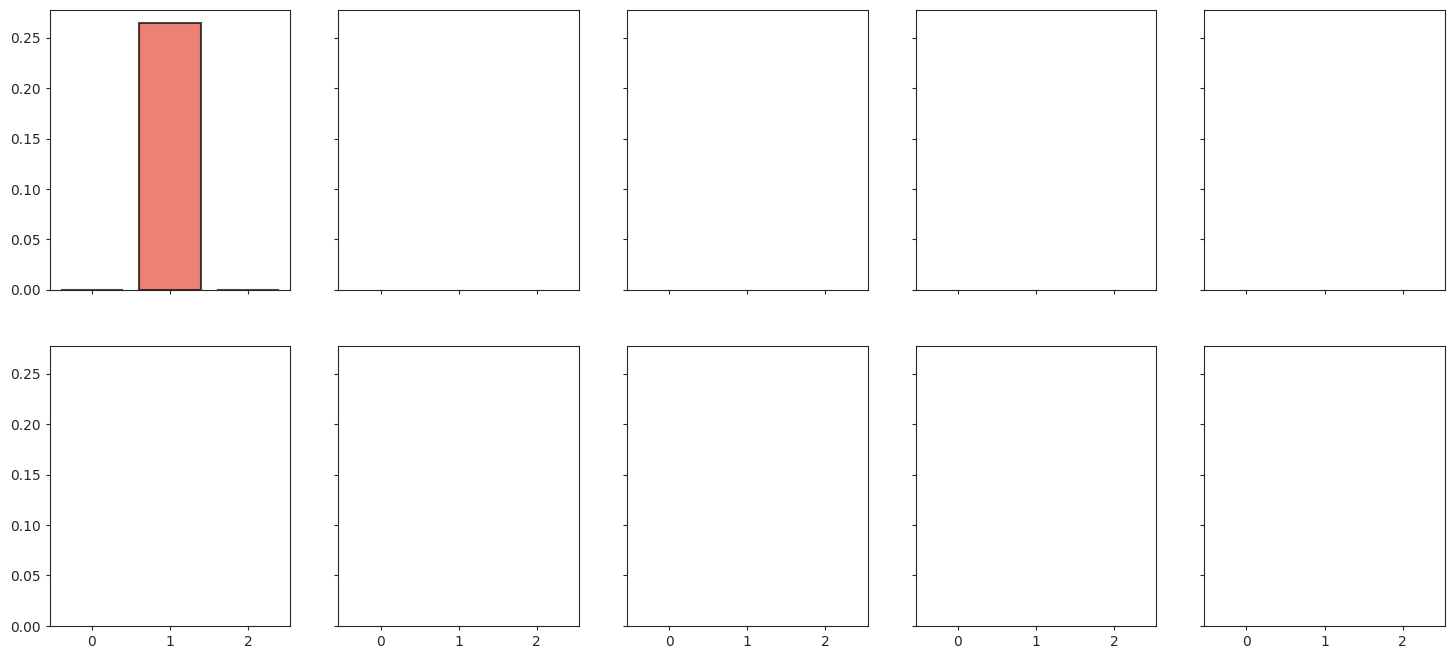

In [ ]:
print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Load LMI data
print("Loading LMI data...")
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))
lmi_df = io.add_reward_col_to_df(lmi_df)

# Add reward group information
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

# Load classifier weights
print("Loading classifier weights...")
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

# Merge datasets on mouse_id and roi
print("Merging datasets...")
data = lmi_df.merge(weights_df[['mouse_id', 'roi', 'classifier_weight', 'classifier_weight_raw']],
                    on=['mouse_id', 'roi'], how='inner')

# Define cell type groups
# non-projectors are cells with NaN in cell_type column
data['cell_type_group'] = data['cell_type'].copy()
data.loc[data['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
data.loc[data['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
data.loc[data['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'

# Keep only the three groups we're interested in
data = data[data['cell_type_group'].isin(['non_projector', 'wS2', 'wM1'])]

print(f"Total cells after merge: {len(data)}")
print(f"Cell type distribution:\n{data['cell_type_group'].value_counts()}")
print(f"Reward group distribution:\n{data['reward_group'].value_counts()}")

# Define criteria globally across all mice
print("\nDefining criteria thresholds...")

# LMI criteria
data['positive_lmi'] = data['lmi_p'] >= 0.975
data['negative_lmi'] = data['lmi_p'] <= 0.025

# Top percentiles for absolute LMI
abs_lmi = np.abs(data['lmi'])
data['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
data['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
data['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Classifier weight criteria - separate by sign
pos_weights = data[data['classifier_weight'] > 0]['classifier_weight']
neg_weights = data[data['classifier_weight'] < 0]['classifier_weight']

data['top_1pct_pos_weight'] = False
data['top_5pct_pos_weight'] = False
data['top_10pct_pos_weight'] = False
data['top_1pct_neg_weight'] = False
data['top_5pct_neg_weight'] = False
data['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    data.loc[data['classifier_weight'] > 0, 'top_1pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    data.loc[data['classifier_weight'] > 0, 'top_5pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    data.loc[data['classifier_weight'] > 0, 'top_10pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    data.loc[data['classifier_weight'] < 0, 'top_1pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    data.loc[data['classifier_weight'] < 0, 'top_5pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    data.loc[data['classifier_weight'] < 0, 'top_10pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

print(f"Positive LMI cells: {data['positive_lmi'].sum()}")
print(f"Negative LMI cells: {data['negative_lmi'].sum()}")
print(f"Top 1% abs LMI: {data['top_1pct_abs_lmi'].sum()}")
print(f"Top 1% positive weights: {data['top_1pct_pos_weight'].sum()}")
print(f"Top 1% negative weights: {data['top_1pct_neg_weight'].sum()}")

# Define all criteria to analyze
criteria = [
    'positive_lmi', 'negative_lmi',
    'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi',
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]

cell_types = ['non_projector', 'wS2', 'wM1']

# Compute proportions and chi-square tests for each reward group separately
print("\nComputing proportions and statistical tests...")

proportions_results = []
chi_square_results = []

for reward_group in ['R+', 'R-']:
    data_rg = data[data['reward_group'] == reward_group]

    print(f"\n{reward_group} Group: {len(data_rg)} cells")

    for criterion in criteria:
        # Create contingency table: rows=cell_type, columns=criterion (met/not met)
        contingency = pd.crosstab(data_rg['cell_type_group'], data_rg[criterion])

        # Ensure both True and False columns exist
        for col in [False, True]:
            if col not in contingency.columns:
                contingency[col] = 0

        # Reorder columns
        contingency = contingency[[False, True]]

        # Calculate proportions for each cell type
        for cell_type in cell_types:
            if cell_type in contingency.index:
                total = contingency.loc[cell_type, :].sum()
                met = contingency.loc[cell_type, True]
                proportion = met / total if total > 0 else 0

                proportions_results.append({
                    'reward_group': reward_group,
                    'cell_type': cell_type,
                    'criterion': criterion,
                    'n_total': int(total),
                    'n_met': int(met),
                    'proportion': proportion
                })

        # Perform chi-square test
        if len(contingency) >= 2 and contingency.shape[1] >= 2:
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': chi2,
                    'p_value': p_value,
                    'dof': dof
                })

                # Print significant results
                if p_value < 0.05:
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} ***")
            except Exception as e:
                print(f"  {criterion}: Chi-square test failed - {e}")
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': np.nan,
                    'p_value': np.nan,
                    'dof': np.nan
                })

# Convert to DataFrames
df_proportions = pd.DataFrame(proportions_results)
df_chi_square = pd.DataFrame(chi_square_results)

# Save results
print("\nSaving results...")
df_proportions.to_csv(os.path.join(output_dir, 'proportions_summary.csv'), index=False)
df_chi_square.to_csv(os.path.join(output_dir, 'chi_square_results.csv'), index=False)

print(f"Saved proportions_summary.csv")
print(f"Saved chi_square_results.csv")

# Create visualizations
print("\nCreating visualizations...")

# Define colors for cell types
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# Figure 1: LMI Proportions
# ==========================
print("  Creating LMI proportions figure...")

lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2))

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_lmi_proportions.svg")

# Figure 2: Classifier Weight Proportions
# ========================================
print("  Creating classifier weight proportions figure...")

weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_labels = [
    'Top 1%\nPos Weight', 'Top 5%\nPos Weight', 'Top 10%\nPos Weight',
    'Top 1%\nNeg Weight', 'Top 5%\nNeg Weight', 'Top 10%\nNeg Weight'
]

fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_weight_proportions.svg")

# Figure 3: Summary Heatmap
# =========================
print("  Creating summary heatmap...")

# Create pivot table for heatmap
heatmap_data = []
for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        row_data = {'reward_group': reward_group, 'cell_type': cell_type}
        for criterion in criteria:
            prop_val = df_proportions[
                (df_proportions['reward_group'] == reward_group) &
                (df_proportions['cell_type'] == cell_type) &
                (df_proportions['criterion'] == criterion)
            ]['proportion'].values
            row_data[criterion] = prop_val[0] if len(prop_val) > 0 else 0
        heatmap_data.append(row_data)

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap['group_label'] = df_heatmap['reward_group'] + ' ' + df_heatmap['cell_type']

# Create heatmap matrix
heatmap_matrix = df_heatmap[criteria].values

fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# Set ticks and labels
ax.set_xticks(np.arange(len(criteria)))
ax.set_yticks(np.arange(len(df_heatmap)))

criterion_labels = [
    'Pos LMI', 'Neg LMI',
    'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI',
    'Top 1%\npos wt', 'Top 5%\npos wt', 'Top 10%\npos wt',
    'Top 1%\nneg wt', 'Top 5%\nneg wt', 'Top 10%\nneg wt'
]

ax.set_xticklabels(criterion_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heatmap['group_label'].values, fontsize=10)

# Add text annotations
for i in range(len(df_heatmap)):
    for j in range(len(criteria)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion', rotation=270, labelpad=20, fontsize=12)

# Add title
ax.set_title('Proportion of Cell Types Meeting Each Criterion', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(criteria))-.5, minor=True)
ax.set_yticks(np.arange(len(df_heatmap))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_summary_heatmap.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_summary_heatmap.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80 + "\n")
print(f"All outputs saved to: {output_dir}")

In [ ]:
weights_df

,mouse_id,roi,classifier_weight,classifier_weight_raw,reward_group,learner_group,sign_flip
0,GF305,0,0.047106,0.047106,R+,R+,1
1,GF305,1,0.084161,0.084161,R+,R+,1
2,GF305,2,0.158698,0.158698,R+,R+,1
3,GF305,3,0.327127,0.327127,R+,R+,1
4,GF305,4,0.178429,0.178429,R+,R+,1
...,...,...,...,...,...,...,...
8775,AR177,87,0.085175,0.085175,R-,bad_learners,1
8776,AR177,105,0.736745,0.736745,R-,bad_learners,1
8777,AR177,108,-0.161734,-0.161734,R-,bad_learners,1
8778,AR177,109,0.354693,0.354693,R-,bad_learners,1


In [ ]:
df_chi_square

""


In [ ]:
chi_square_results

[]

In [ ]:
reward_group

'R+'

In [ ]:
df_proportions

,reward_group,cell_type,criterion,n_total,n_met,proportion
0,R+,wS2,positive_lmi,636,168,0.264151
1,R+,wS2,negative_lmi,636,86,0.135220
2,R+,wS2,top_1pct_abs_lmi,636,10,0.015723
3,R+,wS2,top_5pct_abs_lmi,636,44,0.069182
4,R+,wS2,top_10pct_abs_lmi,636,94,0.147799
5,R+,wS2,top_1pct_pos_weight,636,4,0.006289
6,R+,wS2,top_5pct_pos_weight,636,20,0.031447
7,R+,wS2,top_10pct_pos_weight,636,36,0.056604
8,R+,wS2,top_1pct_neg_weight,636,6,0.009434
9,R+,wS2,top_5pct_neg_weight,636,12,0.018868


In [ ]:
contingency

top_10pct_neg_weight,False,True
cell_type_group,,
wS2,224,30



PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS

Loading LMI data...
Loading classifier weights...
Merging datasets...
Total cells after merge: 1578
Cell type distribution:
cell_type_group
wS2    890
wM1    688
Name: count, dtype: int64
Reward group distribution:
reward_group
R+    1142
R-     436
Name: count, dtype: int64

Defining criteria thresholds...
Positive LMI cells: 317
Negative LMI cells: 253
Top 1% abs LMI: 16
Top 1% positive weights: 8
Top 1% negative weights: 9

Computing proportions and statistical tests...

R+ Group: 1142 cells

R- Group: 436 cells

Saving results...
Saved proportions_summary.csv
Saved chi_square_results.csv

Creating visualizations...
  Creating LMI proportions figure...


KeyError: 'reward_group'

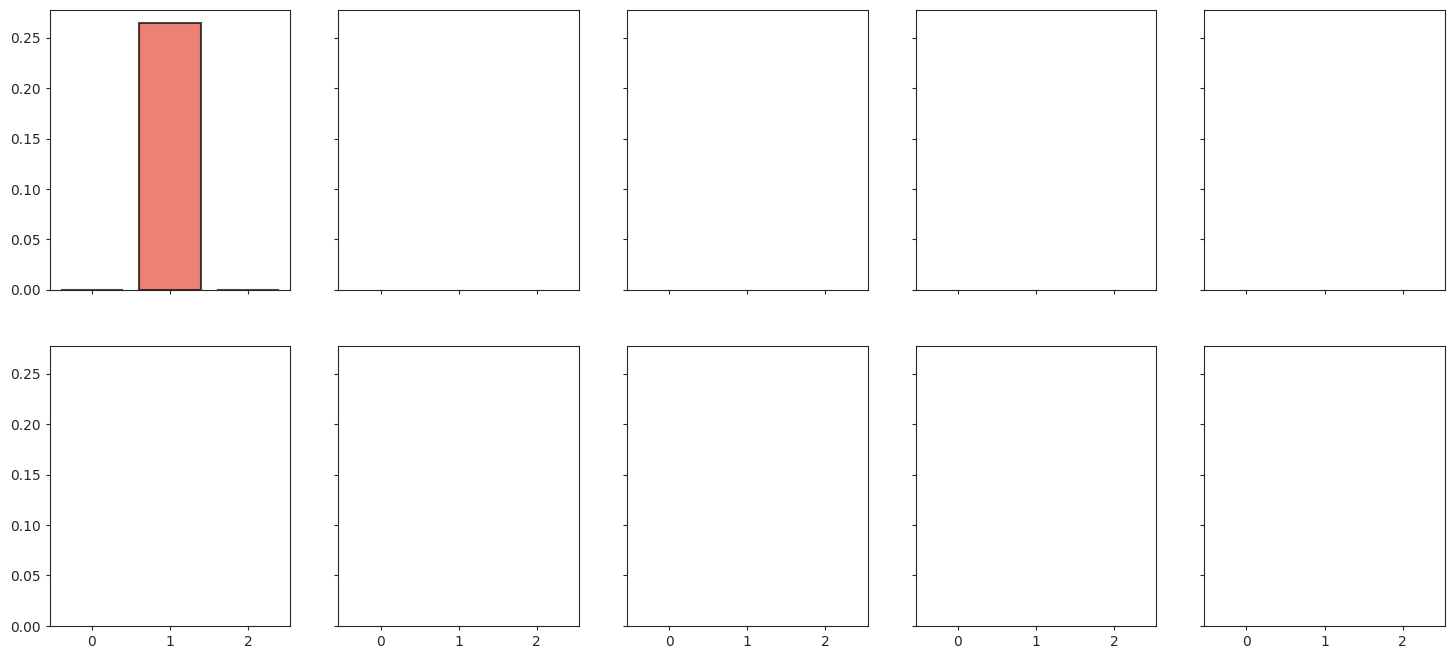

In [ ]:
print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Load LMI data
print("Loading LMI data...")
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))
lmi_df = io.add_reward_col_to_df(lmi_df)

# Add reward group information
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

# Load classifier weights
print("Loading classifier weights...")
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

# Merge datasets on mouse_id and roi
print("Merging datasets...")
data = lmi_df.merge(weights_df[['mouse_id', 'roi', 'classifier_weight', 'classifier_weight_raw']],
                    on=['mouse_id', 'roi'], how='inner')

# Define cell type groups
# non-projectors are cells with NaN in cell_type column
data['cell_type_group'] = data['cell_type'].copy()
data.loc[data['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
data.loc[data['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
data.loc[data['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'

# Keep only the three groups we're interested in
data = data[data['cell_type_group'].isin(['non_projector', 'wS2', 'wM1'])]

print(f"Total cells after merge: {len(data)}")
print(f"Cell type distribution:\n{data['cell_type_group'].value_counts()}")
print(f"Reward group distribution:\n{data['reward_group'].value_counts()}")

# Define criteria globally across all mice
print("\nDefining criteria thresholds...")

# LMI criteria
data['positive_lmi'] = data['lmi_p'] >= 0.975
data['negative_lmi'] = data['lmi_p'] <= 0.025

# Top percentiles for absolute LMI
abs_lmi = np.abs(data['lmi'])
data['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
data['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
data['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Classifier weight criteria - separate by sign
pos_weights = data[data['classifier_weight'] > 0]['classifier_weight']
neg_weights = data[data['classifier_weight'] < 0]['classifier_weight']

data['top_1pct_pos_weight'] = False
data['top_5pct_pos_weight'] = False
data['top_10pct_pos_weight'] = False
data['top_1pct_neg_weight'] = False
data['top_5pct_neg_weight'] = False
data['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    data.loc[data['classifier_weight'] > 0, 'top_1pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    data.loc[data['classifier_weight'] > 0, 'top_5pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    data.loc[data['classifier_weight'] > 0, 'top_10pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    data.loc[data['classifier_weight'] < 0, 'top_1pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    data.loc[data['classifier_weight'] < 0, 'top_5pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    data.loc[data['classifier_weight'] < 0, 'top_10pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

print(f"Positive LMI cells: {data['positive_lmi'].sum()}")
print(f"Negative LMI cells: {data['negative_lmi'].sum()}")
print(f"Top 1% abs LMI: {data['top_1pct_abs_lmi'].sum()}")
print(f"Top 1% positive weights: {data['top_1pct_pos_weight'].sum()}")
print(f"Top 1% negative weights: {data['top_1pct_neg_weight'].sum()}")

# Define all criteria to analyze
criteria = [
    'positive_lmi', 'negative_lmi',
    'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi',
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]

cell_types = ['non_projector', 'wS2', 'wM1']

# Compute proportions and chi-square tests for each reward group separately
print("\nComputing proportions and statistical tests...")

proportions_results = []
chi_square_results = []

for reward_group in ['R+', 'R-']:
    data_rg = data[data['reward_group'] == reward_group]

    print(f"\n{reward_group} Group: {len(data_rg)} cells")

    for criterion in criteria:
        # Create contingency table: rows=cell_type, columns=criterion (met/not met)
        contingency = pd.crosstab(data_rg['cell_type_group'], data_rg[criterion])

        # Ensure both True and False columns exist
        for col in [False, True]:
            if col not in contingency.columns:
                contingency[col] = 0

        # Reorder columns
        contingency = contingency[[False, True]]

        # Calculate proportions for each cell type
        for cell_type in cell_types:
            if cell_type in contingency.index:
                total = contingency.loc[cell_type, :].sum()
                met = contingency.loc[cell_type, True]
                proportion = met / total if total > 0 else 0

                proportions_results.append({
                    'reward_group': reward_group,
                    'cell_type': cell_type,
                    'criterion': criterion,
                    'n_total': int(total),
                    'n_met': int(met),
                    'proportion': proportion
                })

        # Perform chi-square test
        if len(contingency) >= 2 and contingency.shape[1] >= 2:
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': chi2,
                    'p_value': p_value,
                    'dof': dof
                })

                # Print significant results
                if p_value < 0.05:
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} ***")
            except Exception as e:
                print(f"  {criterion}: Chi-square test failed - {e}")
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': np.nan,
                    'p_value': np.nan,
                    'dof': np.nan
                })

# Convert to DataFrames
df_proportions = pd.DataFrame(proportions_results)
df_chi_square = pd.DataFrame(chi_square_results)

# Save results
print("\nSaving results...")
df_proportions.to_csv(os.path.join(output_dir, 'proportions_summary.csv'), index=False)
df_chi_square.to_csv(os.path.join(output_dir, 'chi_square_results.csv'), index=False)

print(f"Saved proportions_summary.csv")
print(f"Saved chi_square_results.csv")

# Create visualizations
print("\nCreating visualizations...")

# Define colors for cell types
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# Figure 1: LMI Proportions
# ==========================
print("  Creating LMI proportions figure...")

lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2))

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_lmi_proportions.svg")

# Figure 2: Classifier Weight Proportions
# ========================================
print("  Creating classifier weight proportions figure...")

weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_labels = [
    'Top 1%\nPos Weight', 'Top 5%\nPos Weight', 'Top 10%\nPos Weight',
    'Top 1%\nNeg Weight', 'Top 5%\nNeg Weight', 'Top 10%\nNeg Weight'
]

fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_weight_proportions.svg")

# Figure 3: Summary Heatmap
# =========================
print("  Creating summary heatmap...")

# Create pivot table for heatmap
heatmap_data = []
for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        row_data = {'reward_group': reward_group, 'cell_type': cell_type}
        for criterion in criteria:
            prop_val = df_proportions[
                (df_proportions['reward_group'] == reward_group) &
                (df_proportions['cell_type'] == cell_type) &
                (df_proportions['criterion'] == criterion)
            ]['proportion'].values
            row_data[criterion] = prop_val[0] if len(prop_val) > 0 else 0
        heatmap_data.append(row_data)

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap['group_label'] = df_heatmap['reward_group'] + ' ' + df_heatmap['cell_type']

# Create heatmap matrix
heatmap_matrix = df_heatmap[criteria].values

fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# Set ticks and labels
ax.set_xticks(np.arange(len(criteria)))
ax.set_yticks(np.arange(len(df_heatmap)))

criterion_labels = [
    'Pos LMI', 'Neg LMI',
    'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI',
    'Top 1%\npos wt', 'Top 5%\npos wt', 'Top 10%\npos wt',
    'Top 1%\nneg wt', 'Top 5%\nneg wt', 'Top 10%\nneg wt'
]

ax.set_xticklabels(criterion_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heatmap['group_label'].values, fontsize=10)

# Add text annotations
for i in range(len(df_heatmap)):
    for j in range(len(criteria)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion', rotation=270, labelpad=20, fontsize=12)

# Add title
ax.set_title('Proportion of Cell Types Meeting Each Criterion', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(criteria))-.5, minor=True)
ax.set_yticks(np.arange(len(df_heatmap))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_summary_heatmap.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_summary_heatmap.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80 + "\n")
print(f"All outputs saved to: {output_dir}")

In [ ]:
chi_square_results

[]

In [ ]:
chi2

NameError: name 'chi2' is not defined

In [ ]:
chi2_contingency

<function scipy.stats.contingency.chi2_contingency(observed, correction=True, lambda_=None, *, method=None)>

In [ ]:
chi2_contingency(contingency)

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=0, expected_freq=array([[224.,  30.]]))


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS

Loading LMI data...
Loading classifier weights...
Merging datasets...
Total cells after merge: 1578
Cell type distribution:
cell_type_group
wS2    890
wM1    688
Name: count, dtype: int64
Reward group distribution:
reward_group
R+    1142
R-     436
Name: count, dtype: int64

Defining criteria thresholds...
Positive LMI cells: 317
Negative LMI cells: 253
Top 1% abs LMI: 16
Top 1% positive weights: 8
Top 1% negative weights: 9

Computing proportions and statistical tests...

R+ Group: 1142 cells
  Contingency table shape: (3, 2)
  Cell types in index: ['non_projector', 'wS2', 'wM1']
  Sample contingency table for positive_lmi:
positive_lmi     False  True 
cell_type_group              
non_projector        0      0
wS2                468    168
wM1                  0      0
  positive_lmi: Skipped - insufficient variation (has_variation=False, has_both_outcomes=True)
  negative_lmi: Skipped - insufficient variation (has_var

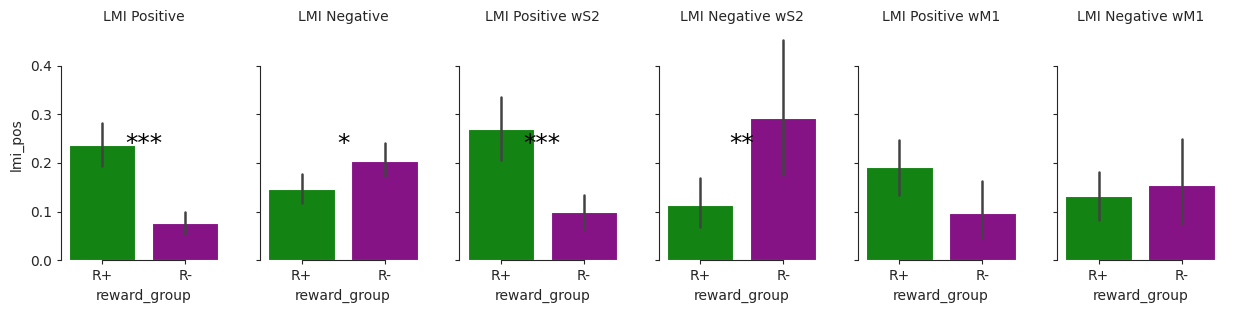

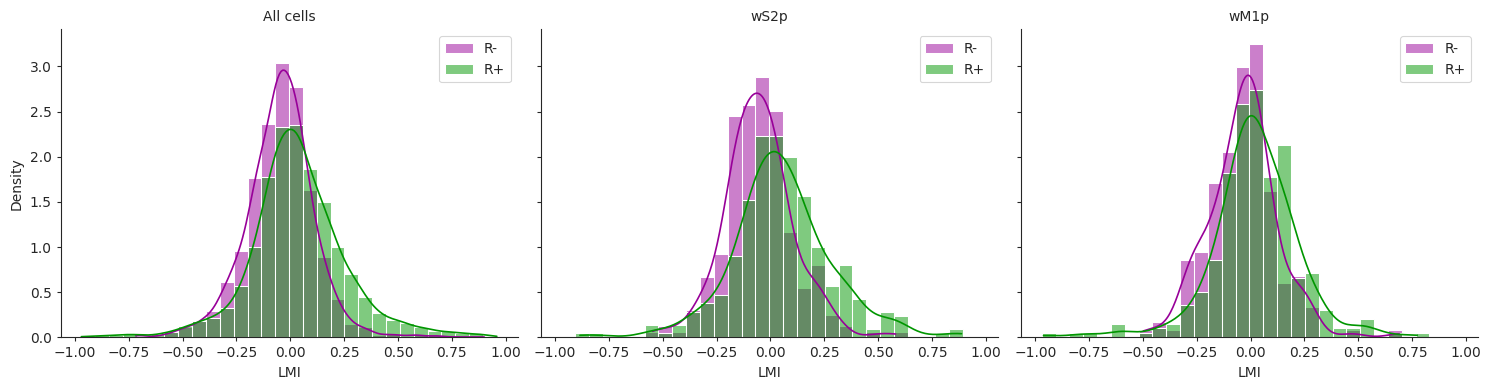

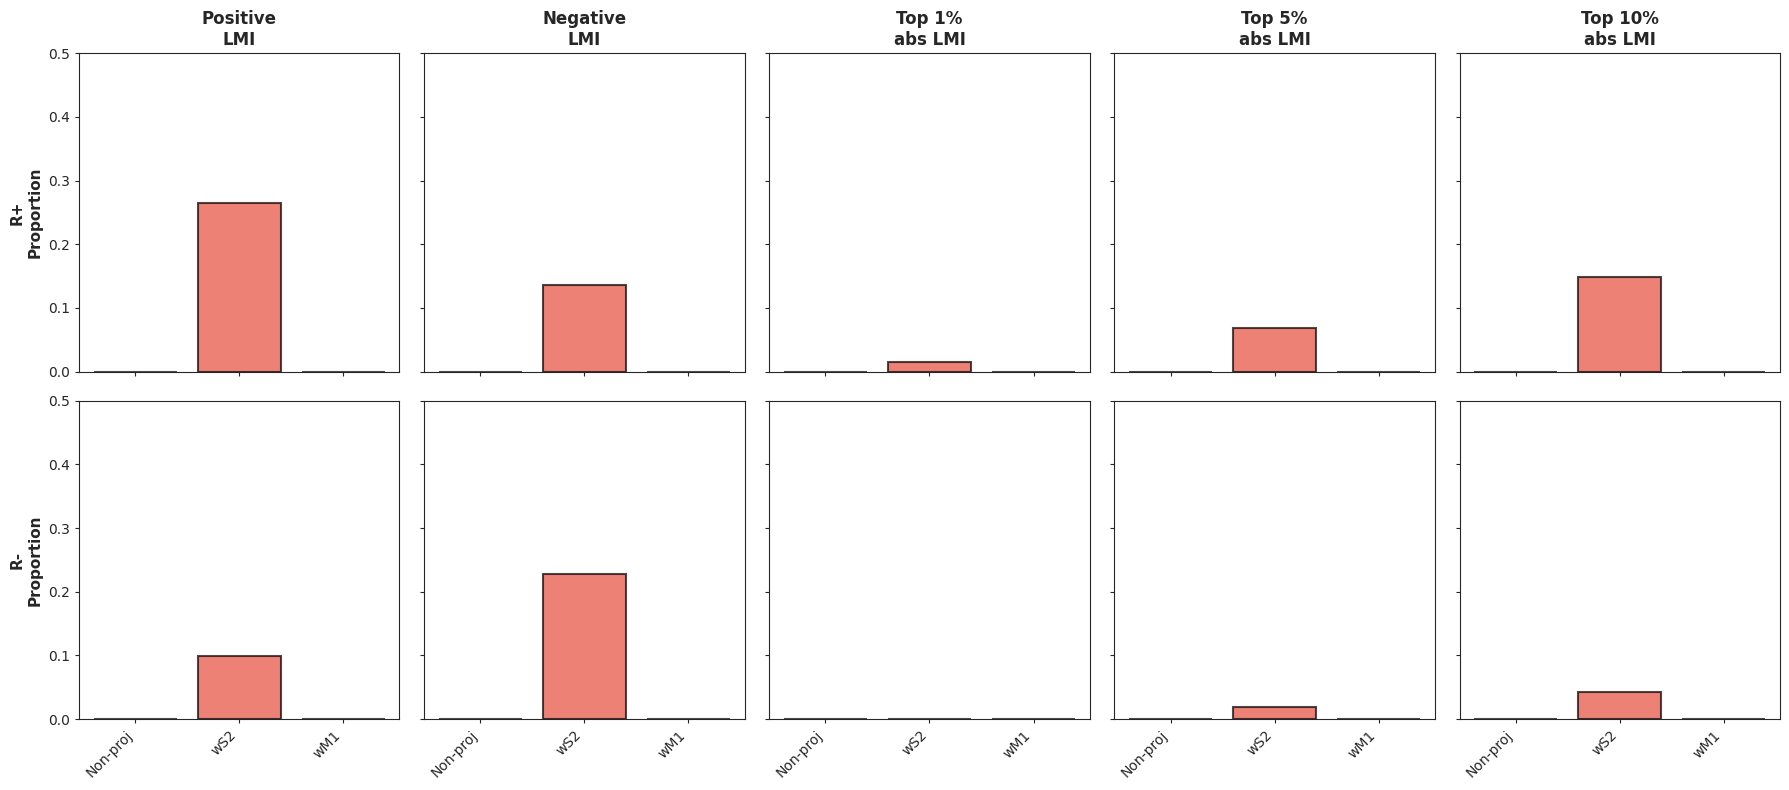

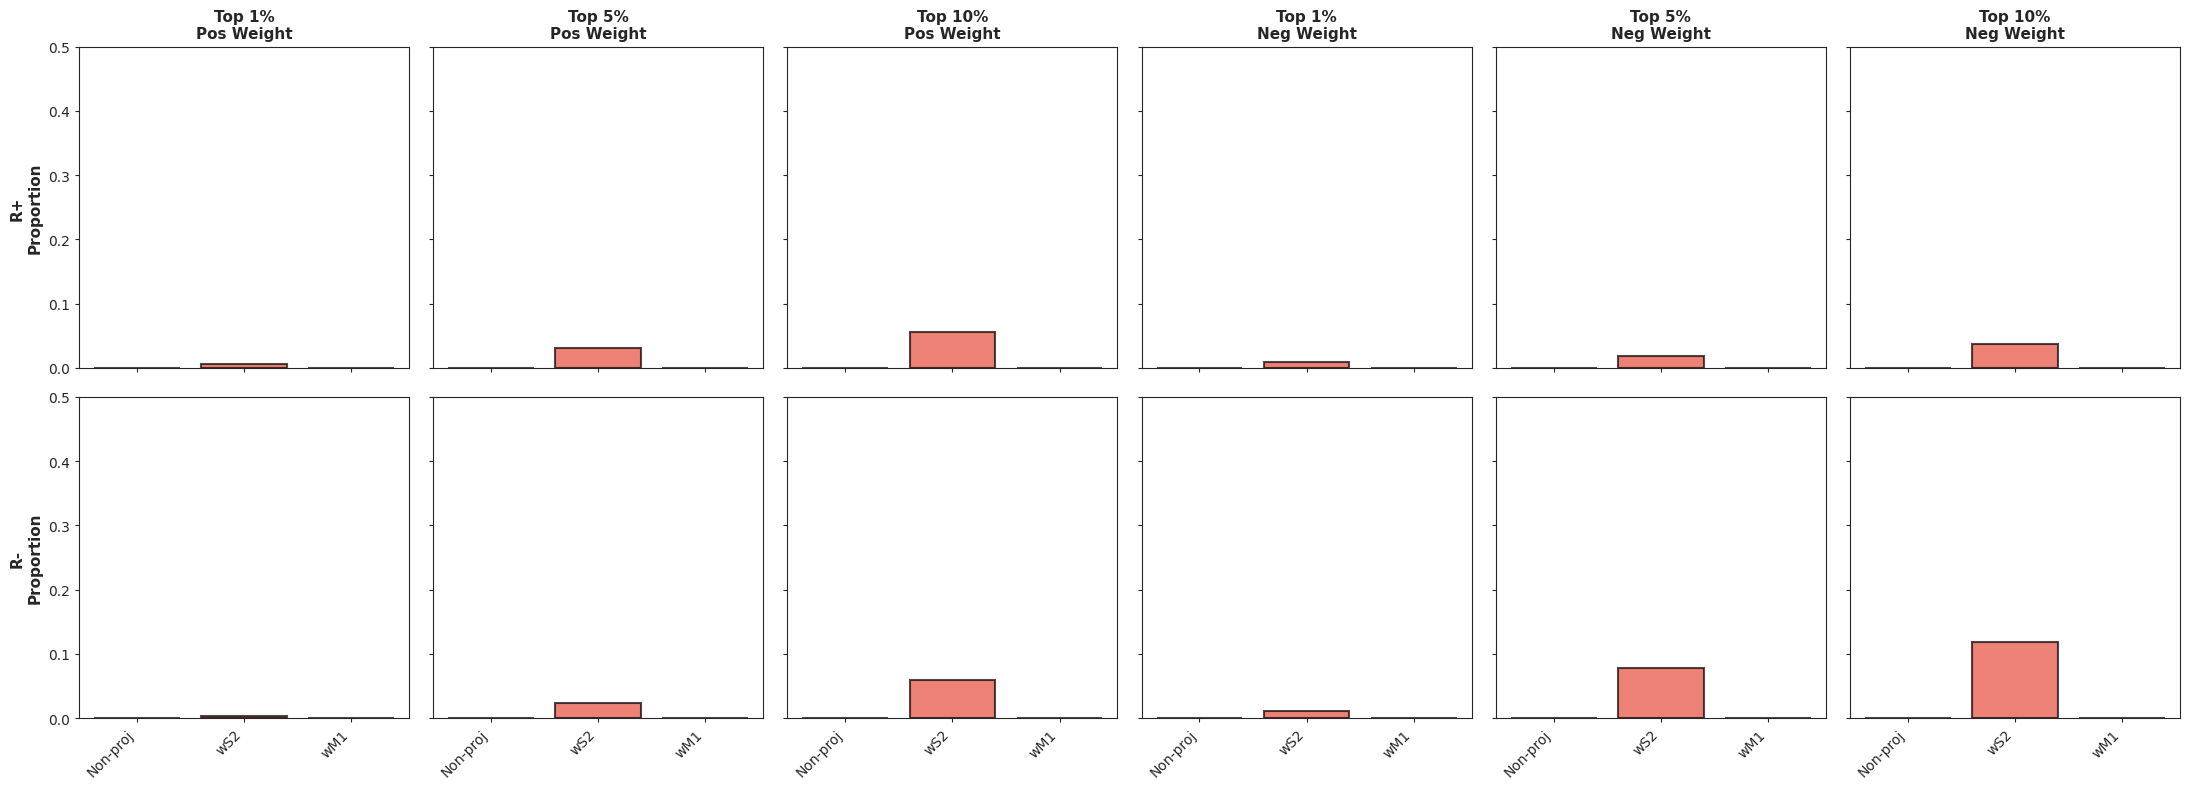

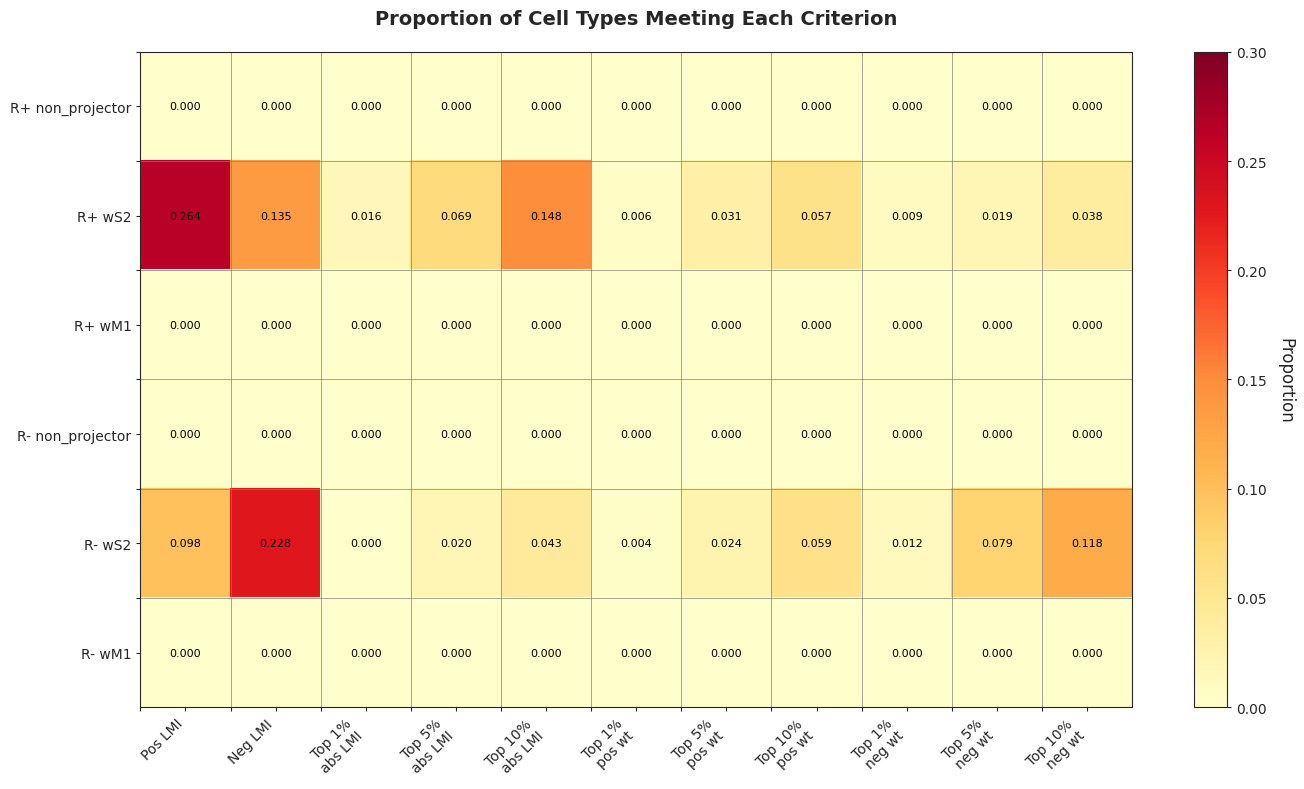

In [ ]:
# #############################################################################
# Proportion of LMI.
# #############################################################################

processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

_, _, mice, _ = io.select_sessions_from_db(io.db_path,
                                            io.nwb_dir,
                                            two_p_imaging='yes',)

for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

lmi_df = lmi_df.loc[lmi_df.mouse_id.isin(mice)]

lmi_df['lmi_pos'] = lmi_df['lmi_p'] >= 0.975
lmi_df['lmi_neg'] = lmi_df['lmi_p'] <= 0.025

lmi_prop = lmi_df.groupby(['mouse_id', 'reward_group'])[['lmi_pos', 'lmi_neg']].apply(lambda x: x.sum() / x.count()).reset_index()
lmi_prop_ct = lmi_df.groupby(['mouse_id', 'reward_group', 'cell_type'])[['lmi_pos', 'lmi_neg']].apply(lambda x: x.sum() / x.count()).reset_index()

# Stats.
# Perform Mann-Whitney U test for each LMI group.
results = []
groups = ['lmi_pos', 'lmi_neg']
cell_types = [None, 'wS2', 'wM1']

for group in groups:
    for cell_type in cell_types:
        if cell_type:
            data = lmi_prop_ct[lmi_prop_ct.cell_type == cell_type]
        else:
            data = lmi_prop

        r_plus = data[data.reward_group == 'R+'][group]
        r_minus = data[data.reward_group == 'R-'][group]

        stat, p_value = mannwhitneyu(r_plus, r_minus, alternative='two-sided')
        results.append({
            'group': group,
            'cell_type': cell_type if cell_type else 'all',
            'stat': stat,
            'p_value': p_value
        })
results_df = pd.DataFrame(results)
output_dir = fr'/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/cell_proportions/'
results_df.to_csv(os.path.join(output_dir, 'prop_lmi_mannwhitney_results.csv'), index=False)

# Plot.
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
sns.barplot(data=lmi_prop, x='reward_group', order=['R+', 'R-'], hue='reward_group', y='lmi_pos', ax=axes[0], palette=reward_palette, hue_order=['R-', 'R+'], legend=False)
axes[0].set_title('LMI Positive')
sns.barplot(data=lmi_prop, x='reward_group',  order=['R+', 'R-'], hue='reward_group', y='lmi_neg',  ax=axes[1], palette=reward_palette, hue_order=['R-', 'R+'], legend=False)
axes[1].set_title('LMI Negative')
sns.barplot(data=lmi_prop_ct.loc[lmi_prop_ct.cell_type=='wS2'], x='reward_group',  order=['R+', 'R-'], hue='reward_group', y='lmi_pos', ax=axes[2], palette=reward_palette, hue_order=['R-', 'R+'], legend=False)
axes[2].set_title('LMI Positive wS2')
sns.barplot(data=lmi_prop_ct.loc[lmi_prop_ct.cell_type=='wS2'], x='reward_group',  order=['R+', 'R-'], hue='reward_group', y='lmi_neg', ax=axes[3], palette=reward_palette, hue_order=['R-', 'R+'], legend=False)
axes[3].set_title('LMI Negative wS2')
sns.barplot(data=lmi_prop_ct.loc[lmi_prop_ct.cell_type=='wM1'], x='reward_group',  order=['R+', 'R-'], hue='reward_group', y='lmi_pos', ax=axes[4], palette=reward_palette, hue_order=['R-', 'R+'], legend=False)
axes[4].set_title('LMI Positive wM1')
sns.barplot(data=lmi_prop_ct.loc[lmi_prop_ct.cell_type=='wM1'], x='reward_group',  order=['R+', 'R-'], hue='reward_group', y='lmi_neg', ax=axes[5], palette=reward_palette, hue_order=['R-', 'R+'], legend=False)
axes[5].set_title('LMI Negative wM1')
sns.despine(trim=True)

# Add stars to plots according to computed stats
def get_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

for i, (group, cell_type) in enumerate([
    ('lmi_pos', None),
    ('lmi_neg', None),
    ('lmi_pos', 'wS2'),
    ('lmi_neg', 'wS2'),
    ('lmi_pos', 'wM1'),
    ('lmi_neg', 'wM1')
]):
    stat_row = results_df[(results_df['group'] == group) & (results_df['cell_type'] == (cell_type if cell_type else 'all'))]
    if not stat_row.empty:
        p = stat_row.iloc[0]['p_value']
        star = get_star(p)
        # Add star annotation between bars
        y_max = axes[i].get_ylim()[1]
        axes[i].annotate(star, xy=(0.5, y_max*0.95), xycoords='axes fraction', ha='center', va='bottom', fontsize=18, color='black')

# Save figure and data.
svg_file = f'prop_lmi.svg'
plt.savefig(os.path.join(output_dir, svg_file), format='svg', dpi=300)
lmi_prop.to_csv(os.path.join(output_dir, 'prop_lmi.csv'), index=False)
lmi_prop_ct.to_csv(os.path.join(output_dir, 'prop_lmi_ct.csv'), index=False)
 
 
# LMI distribution across mice: average curve and confidence interval (variance).
# Use common bin edges for all three plots
bin_edges = np.histogram_bin_edges(lmi_df['lmi'], bins=30)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
cell_types = [None, 'wS2', 'wM1']
titles = ['All cells', 'wS2p', 'wM1p']

for i, cell_type in enumerate(cell_types):
    if cell_type:
        data = lmi_df[lmi_df.cell_type == cell_type]
    else:
        data = lmi_df

    for rg, color in zip(['R-', 'R+'], reward_palette):
        sns.histplot(
            data[data.reward_group == rg]['lmi'],
            bins=bin_edges,
            kde=True,
            ax=axes[i],
            color=color,
            label=rg,
            stat='density',
            alpha=0.5,
        )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('LMI')
    axes[i].legend()

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'lmi_histograms.svg'), format='svg', dpi=300)
# Statistical test: Kolmogorov-Smirnov test for LMI distributions

ks_results = []
for cell_type in cell_types:
    if cell_type:
        data = lmi_df[lmi_df.cell_type == cell_type]
    else:
        data = lmi_df
    lmi_r_minus = data[data.reward_group == 'R-']['lmi']
    lmi_r_plus = data[data.reward_group == 'R+']['lmi']
    stat, p = ks_2samp(lmi_r_minus, lmi_r_plus)
    ks_results.append({'cell_type': cell_type if cell_type else 'all', 'stat': stat, 'p_value': p})

pd.DataFrame(ks_results).to_csv(os.path.join(output_dir, 'lmi_distribution_ks.csv'), index=False)


# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# #############################################################################

print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Load LMI data
print("Loading LMI data...")
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))
lmi_df = io.add_reward_col_to_df(lmi_df)

# Add reward group information
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

# Load classifier weights
print("Loading classifier weights...")
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

# Merge datasets on mouse_id and roi
print("Merging datasets...")
data = lmi_df.merge(weights_df[['mouse_id', 'roi', 'classifier_weight', 'classifier_weight_raw']],
                    on=['mouse_id', 'roi'], how='inner')

# Define cell type groups
# non-projectors are cells with NaN in cell_type column
data['cell_type_group'] = data['cell_type'].copy()
data.loc[data['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
data.loc[data['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
data.loc[data['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'

# Keep only the three groups we're interested in
data = data[data['cell_type_group'].isin(['non_projector', 'wS2', 'wM1'])]

print(f"Total cells after merge: {len(data)}")
print(f"Cell type distribution:\n{data['cell_type_group'].value_counts()}")
print(f"Reward group distribution:\n{data['reward_group'].value_counts()}")

# Define criteria globally across all mice
print("\nDefining criteria thresholds...")

# LMI criteria
data['positive_lmi'] = data['lmi_p'] >= 0.975
data['negative_lmi'] = data['lmi_p'] <= 0.025

# Top percentiles for absolute LMI
abs_lmi = np.abs(data['lmi'])
data['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
data['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
data['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Classifier weight criteria - separate by sign
pos_weights = data[data['classifier_weight'] > 0]['classifier_weight']
neg_weights = data[data['classifier_weight'] < 0]['classifier_weight']

data['top_1pct_pos_weight'] = False
data['top_5pct_pos_weight'] = False
data['top_10pct_pos_weight'] = False
data['top_1pct_neg_weight'] = False
data['top_5pct_neg_weight'] = False
data['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    data.loc[data['classifier_weight'] > 0, 'top_1pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    data.loc[data['classifier_weight'] > 0, 'top_5pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    data.loc[data['classifier_weight'] > 0, 'top_10pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    data.loc[data['classifier_weight'] < 0, 'top_1pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    data.loc[data['classifier_weight'] < 0, 'top_5pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    data.loc[data['classifier_weight'] < 0, 'top_10pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

print(f"Positive LMI cells: {data['positive_lmi'].sum()}")
print(f"Negative LMI cells: {data['negative_lmi'].sum()}")
print(f"Top 1% abs LMI: {data['top_1pct_abs_lmi'].sum()}")
print(f"Top 1% positive weights: {data['top_1pct_pos_weight'].sum()}")
print(f"Top 1% negative weights: {data['top_1pct_neg_weight'].sum()}")

# Define all criteria to analyze
criteria = [
    'positive_lmi', 'negative_lmi',
    'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi',
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]

cell_types = ['non_projector', 'wS2', 'wM1']

# Compute proportions and chi-square tests for each reward group separately
print("\nComputing proportions and statistical tests...")

proportions_results = []
chi_square_results = []

for reward_group in ['R+', 'R-']:
    data_rg = data[data['reward_group'] == reward_group]

    print(f"\n{reward_group} Group: {len(data_rg)} cells")

    for criterion in criteria:
        # Create contingency table: rows=cell_type, columns=criterion (met/not met)
        contingency = pd.crosstab(data_rg['cell_type_group'], data_rg[criterion])

        # Ensure both True and False columns exist
        for col in [False, True]:
            if col not in contingency.columns:
                contingency[col] = 0

        # Reorder columns
        contingency = contingency[[False, True]]

        # Ensure all cell types are represented (even if they have 0 counts)
        for cell_type in cell_types:
            if cell_type not in contingency.index:
                contingency.loc[cell_type] = [0, 0]

        # Reorder rows to ensure consistent order
        contingency = contingency.loc[cell_types]

        # Calculate proportions for each cell type
        for cell_type in cell_types:
            total = contingency.loc[cell_type, :].sum()
            met = contingency.loc[cell_type, True]
            proportion = met / total if total > 0 else 0

            proportions_results.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': int(total),
                'n_met': int(met),
                'proportion': proportion
            })

        # Debug: Print contingency table info
        if criterion == criteria[0]:  # Only print for first criterion to avoid clutter
            print(f"  Contingency table shape: {contingency.shape}")
            print(f"  Cell types in index: {list(contingency.index)}")
            print(f"  Sample contingency table for {criterion}:")
            print(contingency)

        # Perform chi-square test
        # Need at least 2 rows and 2 columns, and at least some non-zero cells
        has_variation = (contingency.sum(axis=1) > 0).sum() >= 2  # At least 2 cell types with data
        has_both_outcomes = (contingency.sum(axis=0) > 0).sum() >= 2  # Both met and not-met categories exist

        if has_variation and has_both_outcomes:
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': chi2,
                    'p_value': p_value,
                    'dof': dof
                })

                # Print significant results
                if p_value < 0.05:
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} ***")
                elif criterion in criteria[:2]:  # Print first few for debugging
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} (n.s.)")

            except Exception as e:
                print(f"  {criterion}: Chi-square test failed - {e}")
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': np.nan,
                    'p_value': np.nan,
                    'dof': np.nan
                })
        else:
            print(f"  {criterion}: Skipped - insufficient variation (has_variation={has_variation}, has_both_outcomes={has_both_outcomes})")
            chi_square_results.append({
                'reward_group': reward_group,
                'criterion': criterion,
                'chi2': np.nan,
                'p_value': np.nan,
                'dof': np.nan
            })

# Convert to DataFrames
df_proportions = pd.DataFrame(proportions_results)
df_chi_square = pd.DataFrame(chi_square_results)

# Save results
print("\nSaving results...")
df_proportions.to_csv(os.path.join(output_dir, 'proportions_summary.csv'), index=False)
df_chi_square.to_csv(os.path.join(output_dir, 'chi_square_results.csv'), index=False)

print(f"Saved proportions_summary.csv")
print(f"Saved chi_square_results.csv")

# Create visualizations
print("\nCreating visualizations...")

# Define colors for cell types
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# Figure 1: LMI Proportions
# ==========================
print("  Creating LMI proportions figure...")

lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2))

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_lmi_proportions.svg")

# Figure 2: Classifier Weight Proportions
# ========================================
print("  Creating classifier weight proportions figure...")

weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_labels = [
    'Top 1%\nPos Weight', 'Top 5%\nPos Weight', 'Top 10%\nPos Weight',
    'Top 1%\nNeg Weight', 'Top 5%\nNeg Weight', 'Top 10%\nNeg Weight'
]

fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_weight_proportions.svg")

# Figure 3: Summary Heatmap
# =========================
print("  Creating summary heatmap...")

# Create pivot table for heatmap
heatmap_data = []
for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        row_data = {'reward_group': reward_group, 'cell_type': cell_type}
        for criterion in criteria:
            prop_val = df_proportions[
                (df_proportions['reward_group'] == reward_group) &
                (df_proportions['cell_type'] == cell_type) &
                (df_proportions['criterion'] == criterion)
            ]['proportion'].values
            row_data[criterion] = prop_val[0] if len(prop_val) > 0 else 0
        heatmap_data.append(row_data)

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap['group_label'] = df_heatmap['reward_group'] + ' ' + df_heatmap['cell_type']

# Create heatmap matrix
heatmap_matrix = df_heatmap[criteria].values

fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# Set ticks and labels
ax.set_xticks(np.arange(len(criteria)))
ax.set_yticks(np.arange(len(df_heatmap)))

criterion_labels = [
    'Pos LMI', 'Neg LMI',
    'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI',
    'Top 1%\npos wt', 'Top 5%\npos wt', 'Top 10%\npos wt',
    'Top 1%\nneg wt', 'Top 5%\nneg wt', 'Top 10%\nneg wt'
]

ax.set_xticklabels(criterion_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heatmap['group_label'].values, fontsize=10)

# Add text annotations
for i in range(len(df_heatmap)):
    for j in range(len(criteria)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion', rotation=270, labelpad=20, fontsize=12)

# Add title
ax.set_title('Proportion of Cell Types Meeting Each Criterion', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(criteria))-.5, minor=True)
ax.set_yticks(np.arange(len(df_heatmap))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_summary_heatmap.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_summary_heatmap.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80 + "\n")
print(f"All outputs saved to: {output_dir}")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS

Loading LMI data...
LMI data: 6060 cells from 35 mice
LMI cell_type values:
cell_type
na     4989
wS2     582
wM1     489
Name: count, dtype: int64

Loading classifier weights...
Weights data: 8780 cells from 34 mice
Unique mice in weights: ['AR127', 'AR132', 'AR133', 'AR137', 'AR139', 'AR143', 'AR163', 'AR176', 'AR177', 'AR178', 'AR179', 'AR180', 'AR185', 'AR187', 'GF305', 'GF306', 'GF307', 'GF308', 'GF311', 'GF313', 'GF314', 'GF317', 'GF318', 'GF319', 'GF323', 'GF333', 'GF334', 'GF348', 'GF350', 'MI062', 'MI069', 'MI072', 'MI075', 'MI076']
Unique mice in LMI: ['AR127', 'AR132', 'AR133', 'AR137', 'AR139', 'AR143', 'AR163', 'AR176', 'AR177', 'AR178', 'AR179', 'AR180', 'AR185', 'AR187', 'GF305', 'GF306', 'GF307', 'GF308', 'GF310', 'GF311', 'GF313', 'GF314', 'GF317', 'GF318', 'GF319', 'GF323', 'GF333', 'GF334', 'GF348', 'GF350', 'MI062', 'MI069', 'MI072', 'MI075', 'MI076']

Common mice: 34 - ['AR127', 'AR132', 'AR133', 'AR13

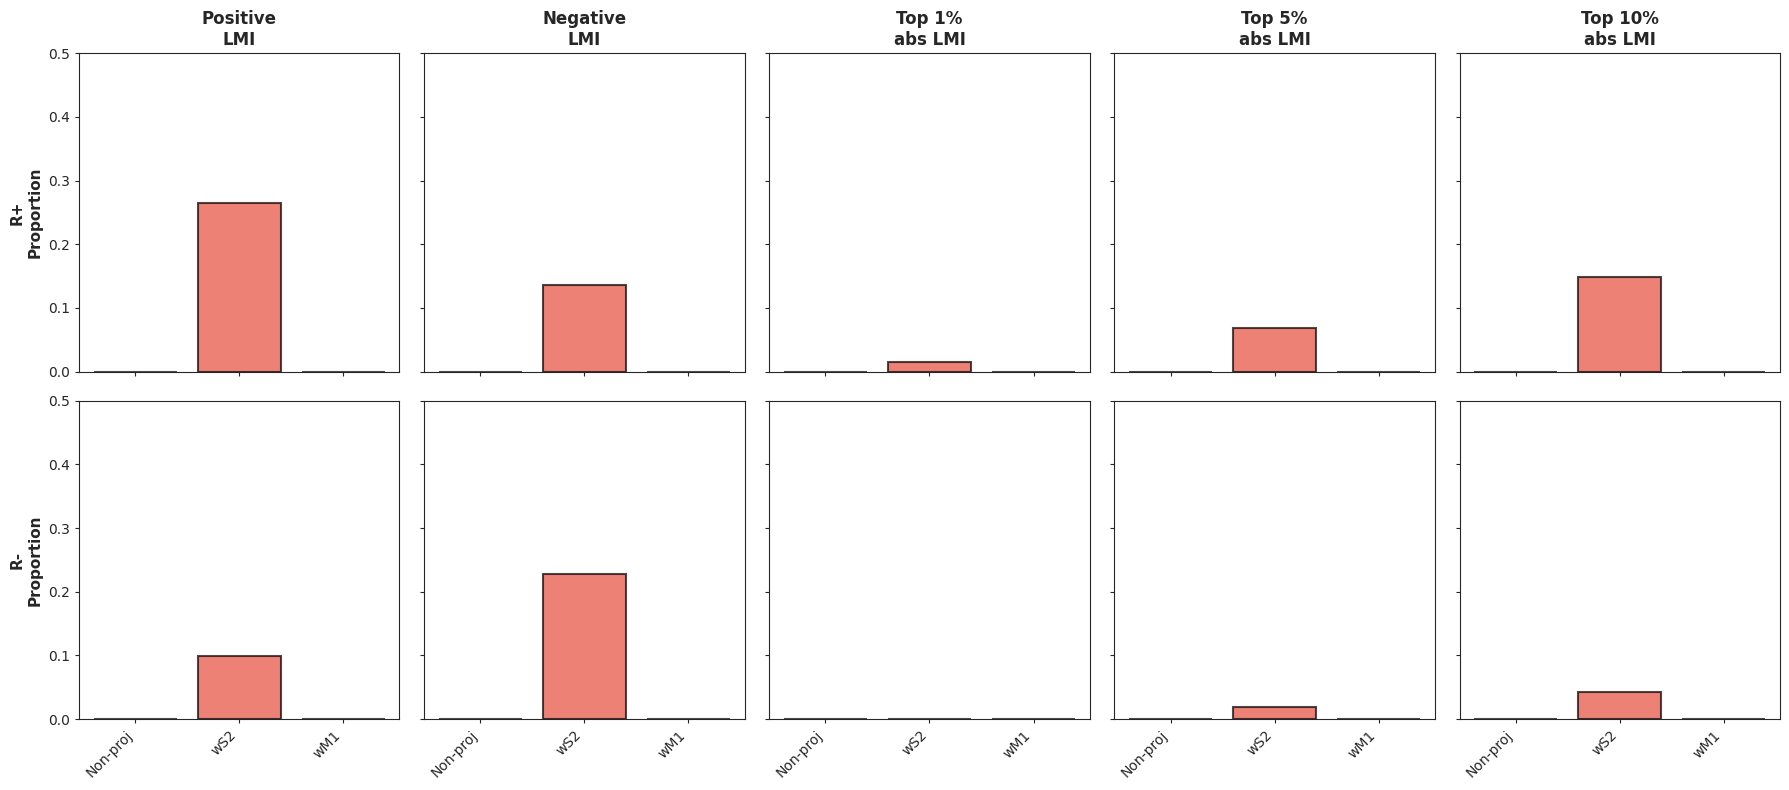

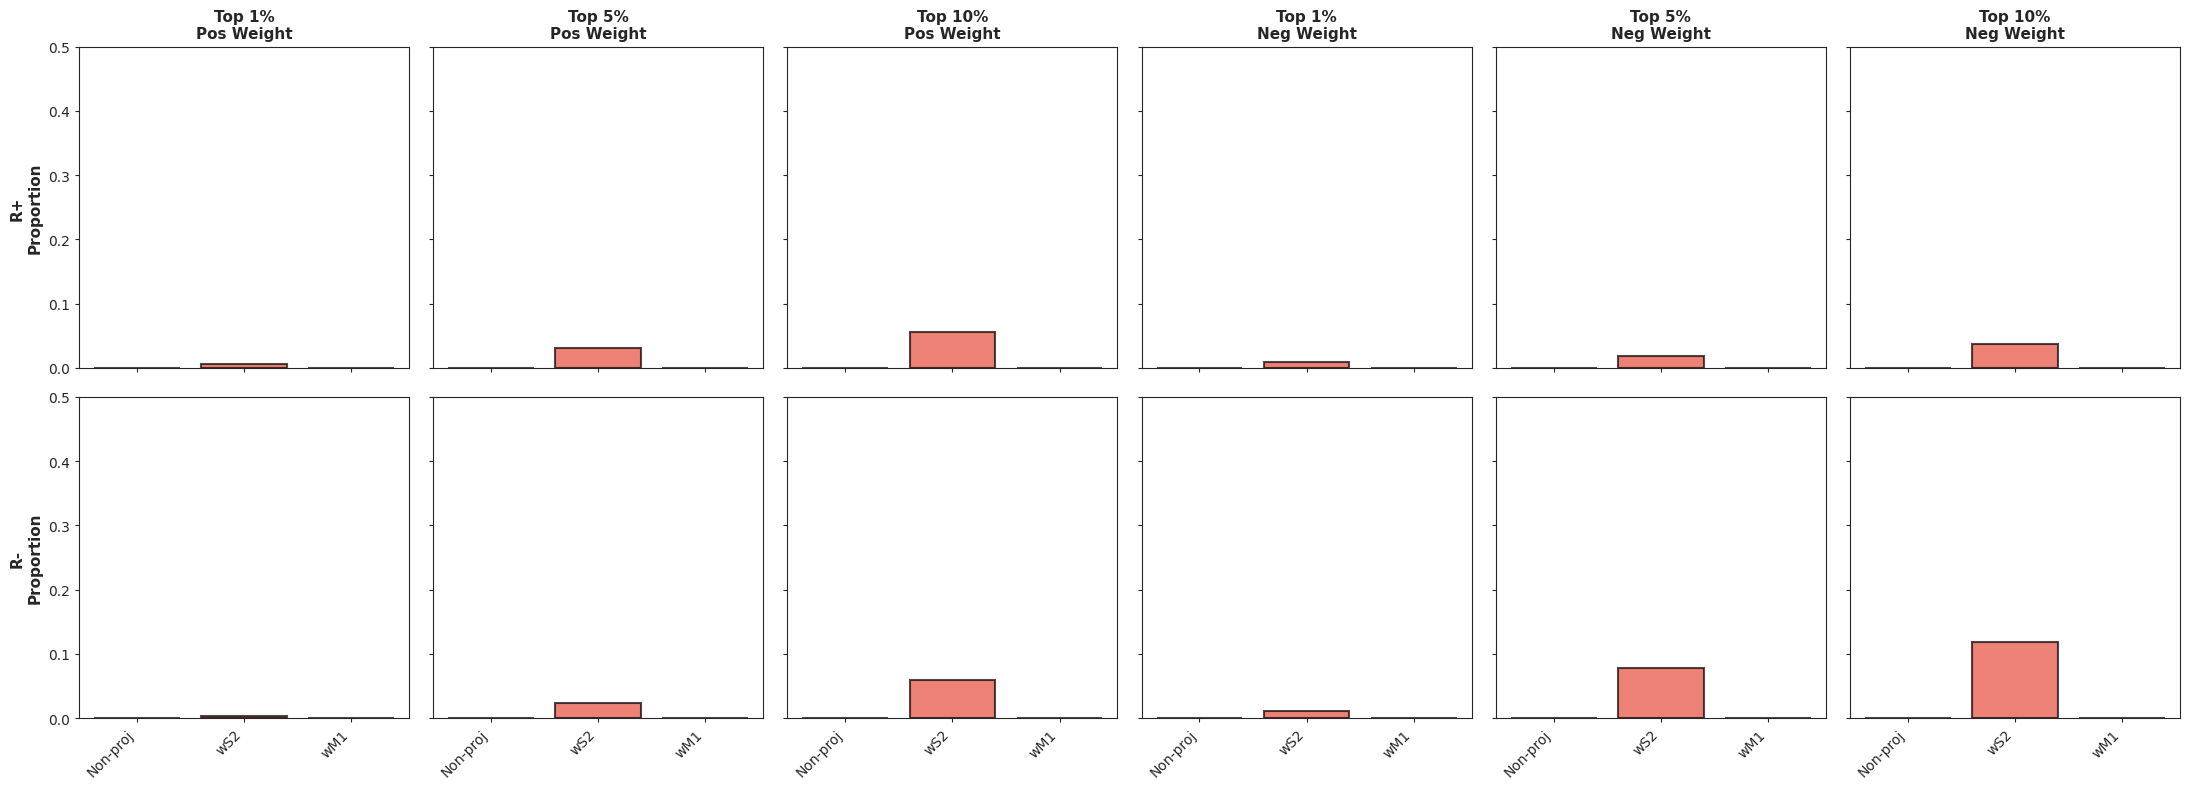

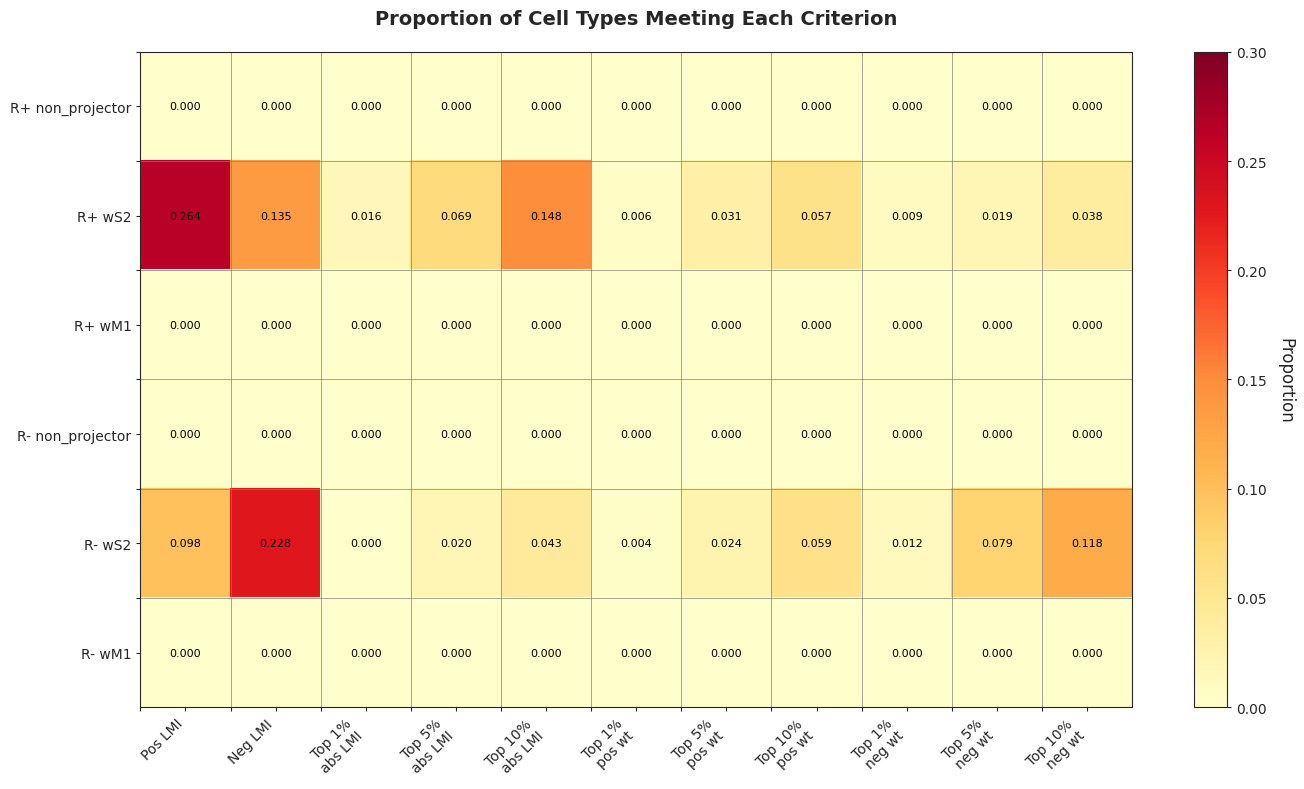

In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# #############################################################################

print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Load LMI data
print("Loading LMI data...")
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))
lmi_df = io.add_reward_col_to_df(lmi_df)

# Add reward group information
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")
print(f"LMI cell_type values:\n{lmi_df['cell_type'].value_counts(dropna=False)}")

# Load classifier weights
print("\nLoading classifier weights...")
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")
print(f"Unique mice in weights: {sorted(weights_df['mouse_id'].unique())}")
print(f"Unique mice in LMI: {sorted(lmi_df['mouse_id'].unique())}")

# Check overlap
common_mice = set(lmi_df['mouse_id'].unique()) & set(weights_df['mouse_id'].unique())
print(f"\nCommon mice: {len(common_mice)} - {sorted(common_mice)}")

# Merge datasets on mouse_id and roi
print("\nMerging datasets...")
data = lmi_df.merge(weights_df[['mouse_id', 'roi', 'classifier_weight', 'classifier_weight_raw']],
                    on=['mouse_id', 'roi'], how='inner')

print(f"After merge: {len(data)} cells (lost {len(lmi_df) - len(data)} cells)")

# Check cell_type column before categorization
print(f"\nCell_type values after merge:\n{data['cell_type'].value_counts(dropna=False)}")
print(f"Number of NaN cell_types: {data['cell_type'].isna().sum()}")

# Define cell type groups
# non-projectors are cells with NaN in cell_type column
data['cell_type_group'] = data['cell_type'].copy()
data.loc[data['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
data.loc[data['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
data.loc[data['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'

print(f"\nCell_type_group after assignment:\n{data['cell_type_group'].value_counts(dropna=False)}")

# Keep only the three groups we're interested in
before_filter = len(data)
data = data[data['cell_type_group'].isin(['non_projector', 'wS2', 'wM1'])]
print(f"After filtering to 3 groups: {len(data)} cells (removed {before_filter - len(data)} cells)")

print(f"\nTotal cells after merge: {len(data)}")
print(f"Cell type distribution:\n{data['cell_type_group'].value_counts()}")
print(f"Reward group distribution:\n{data['reward_group'].value_counts()}")

# Check a sample of the data
print("\nSample of merged data:")
print(data[['mouse_id', 'roi', 'cell_type', 'cell_type_group', 'reward_group', 'lmi', 'classifier_weight']].head(20))

# Define criteria globally across all mice
print("\nDefining criteria thresholds...")

# LMI criteria
data['positive_lmi'] = data['lmi_p'] >= 0.975
data['negative_lmi'] = data['lmi_p'] <= 0.025

# Top percentiles for absolute LMI
abs_lmi = np.abs(data['lmi'])
data['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
data['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
data['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Classifier weight criteria - separate by sign
pos_weights = data[data['classifier_weight'] > 0]['classifier_weight']
neg_weights = data[data['classifier_weight'] < 0]['classifier_weight']

data['top_1pct_pos_weight'] = False
data['top_5pct_pos_weight'] = False
data['top_10pct_pos_weight'] = False
data['top_1pct_neg_weight'] = False
data['top_5pct_neg_weight'] = False
data['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    data.loc[data['classifier_weight'] > 0, 'top_1pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    data.loc[data['classifier_weight'] > 0, 'top_5pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    data.loc[data['classifier_weight'] > 0, 'top_10pct_pos_weight'] = data.loc[data['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    data.loc[data['classifier_weight'] < 0, 'top_1pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    data.loc[data['classifier_weight'] < 0, 'top_5pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    data.loc[data['classifier_weight'] < 0, 'top_10pct_neg_weight'] = data.loc[data['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

print(f"Positive LMI cells: {data['positive_lmi'].sum()}")
print(f"Negative LMI cells: {data['negative_lmi'].sum()}")
print(f"Top 1% abs LMI: {data['top_1pct_abs_lmi'].sum()}")
print(f"Top 1% positive weights: {data['top_1pct_pos_weight'].sum()}")
print(f"Top 1% negative weights: {data['top_1pct_neg_weight'].sum()}")

# Define all criteria to analyze
criteria = [
    'positive_lmi', 'negative_lmi',
    'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi',
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]

cell_types = ['non_projector', 'wS2', 'wM1']

# Compute proportions and chi-square tests for each reward group separately
print("\nComputing proportions and statistical tests...")

proportions_results = []
chi_square_results = []

for reward_group in ['R+', 'R-']:
    data_rg = data[data['reward_group'] == reward_group]

    print(f"\n{reward_group} Group: {len(data_rg)} cells")

    for criterion in criteria:
        # Create contingency table: rows=cell_type, columns=criterion (met/not met)
        contingency = pd.crosstab(data_rg['cell_type_group'], data_rg[criterion])

        # Ensure both True and False columns exist
        for col in [False, True]:
            if col not in contingency.columns:
                contingency[col] = 0

        # Reorder columns
        contingency = contingency[[False, True]]

        # Ensure all cell types are represented (even if they have 0 counts)
        for cell_type in cell_types:
            if cell_type not in contingency.index:
                contingency.loc[cell_type] = [0, 0]

        # Reorder rows to ensure consistent order
        contingency = contingency.loc[cell_types]

        # Calculate proportions for each cell type
        for cell_type in cell_types:
            total = contingency.loc[cell_type, :].sum()
            met = contingency.loc[cell_type, True]
            proportion = met / total if total > 0 else 0

            proportions_results.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': int(total),
                'n_met': int(met),
                'proportion': proportion
            })

        # Debug: Print contingency table info
        if criterion == criteria[0]:  # Only print for first criterion to avoid clutter
            print(f"  Contingency table shape: {contingency.shape}")
            print(f"  Cell types in index: {list(contingency.index)}")
            print(f"  Sample contingency table for {criterion}:")
            print(contingency)

        # Perform chi-square test
        # Need at least 2 rows and 2 columns, and at least some non-zero cells
        has_variation = (contingency.sum(axis=1) > 0).sum() >= 2  # At least 2 cell types with data
        has_both_outcomes = (contingency.sum(axis=0) > 0).sum() >= 2  # Both met and not-met categories exist

        if has_variation and has_both_outcomes:
            try:
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': chi2,
                    'p_value': p_value,
                    'dof': dof
                })

                # Print significant results
                if p_value < 0.05:
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} ***")
                elif criterion in criteria[:2]:  # Print first few for debugging
                    print(f"  {criterion}: χ²={chi2:.2f}, p={p_value:.4f} (n.s.)")

            except Exception as e:
                print(f"  {criterion}: Chi-square test failed - {e}")
                chi_square_results.append({
                    'reward_group': reward_group,
                    'criterion': criterion,
                    'chi2': np.nan,
                    'p_value': np.nan,
                    'dof': np.nan
                })
        else:
            print(f"  {criterion}: Skipped - insufficient variation (has_variation={has_variation}, has_both_outcomes={has_both_outcomes})")
            chi_square_results.append({
                'reward_group': reward_group,
                'criterion': criterion,
                'chi2': np.nan,
                'p_value': np.nan,
                'dof': np.nan
            })

# Convert to DataFrames
df_proportions = pd.DataFrame(proportions_results)
df_chi_square = pd.DataFrame(chi_square_results)

# Debug: Check proportions
print("\n" + "="*60)
print("PROPORTIONS SUMMARY")
print("="*60)
print(f"Total proportion records: {len(df_proportions)}")
print("\nNon-zero proportions by cell type:")
for cell_type in cell_types:
    ct_data = df_proportions[df_proportions['cell_type'] == cell_type]
    non_zero = ct_data[ct_data['proportion'] > 0]
    print(f"  {cell_type}: {len(non_zero)}/{len(ct_data)} non-zero proportions")
    if len(non_zero) > 0:
        print(f"    Sample non-zero: {non_zero[['criterion', 'n_met', 'n_total', 'proportion']].head(3).to_string(index=False)}")

print("\nProportions for first criterion (positive_lmi):")
first_crit = df_proportions[df_proportions['criterion'] == 'positive_lmi']
print(first_crit[['reward_group', 'cell_type', 'n_total', 'n_met', 'proportion']].to_string(index=False))

# Save results
print("\n" + "="*60)
print("Saving results...")
df_proportions.to_csv(os.path.join(output_dir, 'proportions_summary.csv'), index=False)
df_chi_square.to_csv(os.path.join(output_dir, 'chi_square_results.csv'), index=False)

print(f"Saved proportions_summary.csv")
print(f"Saved chi_square_results.csv")

# Create visualizations
print("\nCreating visualizations...")

# Define colors for cell types
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# Figure 1: LMI Proportions
# ==========================
print("  Creating LMI proportions figure...")

lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2))

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_lmi_proportions.svg")

# Figure 2: Classifier Weight Proportions
# ========================================
print("  Creating classifier weight proportions figure...")

weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_labels = [
    'Top 1%\nPos Weight', 'Top 5%\nPos Weight', 'Top 10%\nPos Weight',
    'Top 1%\nNeg Weight', 'Top 5%\nNeg Weight', 'Top 10%\nNeg Weight'
]

fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]

        # Get data for this reward group and criterion
        plot_data = df_proportions[
            (df_proportions['reward_group'] == reward_group) &
            (df_proportions['criterion'] == criterion)
        ]

        # Plot bars
        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        colors_list = [cell_type_colors[ct] for ct in cell_types]
        ax.bar(x_pos, proportions, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add p-value annotation
        chi_result = df_chi_square[
            (df_chi_square['reward_group'] == reward_group) &
            (df_chi_square['criterion'] == criterion)
        ]

        if len(chi_result) > 0:
            p_val = chi_result['p_value'].values[0]
            if not np.isnan(p_val):
                if p_val < 0.001:
                    sig_text = '***'
                elif p_val < 0.01:
                    sig_text = '**'
                elif p_val < 0.05:
                    sig_text = '*'
                else:
                    sig_text = 'n.s.'

                ax.text(0.5, 0.95, f'p={p_val:.4f}\n{sig_text}',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=8, fontweight='bold')

        # Formatting
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_weight_proportions.svg")

# Figure 3: Summary Heatmap
# =========================
print("  Creating summary heatmap...")

# Create pivot table for heatmap
heatmap_data = []
for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        row_data = {'reward_group': reward_group, 'cell_type': cell_type}
        for criterion in criteria:
            prop_val = df_proportions[
                (df_proportions['reward_group'] == reward_group) &
                (df_proportions['cell_type'] == cell_type) &
                (df_proportions['criterion'] == criterion)
            ]['proportion'].values
            row_data[criterion] = prop_val[0] if len(prop_val) > 0 else 0
        heatmap_data.append(row_data)

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap['group_label'] = df_heatmap['reward_group'] + ' ' + df_heatmap['cell_type']

# Create heatmap matrix
heatmap_matrix = df_heatmap[criteria].values

fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# Set ticks and labels
ax.set_xticks(np.arange(len(criteria)))
ax.set_yticks(np.arange(len(df_heatmap)))

criterion_labels = [
    'Pos LMI', 'Neg LMI',
    'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI',
    'Top 1%\npos wt', 'Top 5%\npos wt', 'Top 10%\npos wt',
    'Top 1%\nneg wt', 'Top 5%\nneg wt', 'Top 10%\nneg wt'
]

ax.set_xticklabels(criterion_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heatmap['group_label'].values, fontsize=10)

# Add text annotations
for i in range(len(df_heatmap)):
    for j in range(len(criteria)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion', rotation=270, labelpad=20, fontsize=12)

# Add title
ax.set_title('Proportion of Cell Types Meeting Each Criterion', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(criteria))-.5, minor=True)
ax.set_yticks(np.arange(len(df_heatmap))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_summary_heatmap.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved figure_summary_heatmap.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80 + "\n")
print(f"All outputs saved to: {output_dir}")

In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# Simplified: analyze LMI and weights independently (no merge, no statistics).
# #############################################################################


print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

cell_types = ['non_projector', 'wS2', 'wM1']
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# =============================================================================
# PART 1: LMI ANALYSIS
# =============================================================================

print("\nPART 1: LMI ANALYSIS")
print("-" * 80)

# Load LMI data
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")

# Define cell type groups
lmi_df['cell_type_group'] = lmi_df['cell_type'].copy()
lmi_df.loc[lmi_df['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
lmi_df.loc[lmi_df['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
lmi_df.loc[lmi_df['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'
lmi_df = lmi_df[lmi_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {lmi_df['cell_type_group'].value_counts().to_dict()}")

# Define LMI criteria
lmi_df['positive_lmi'] = lmi_df['lmi_p'] >= 0.975
lmi_df['negative_lmi'] = lmi_df['lmi_p'] <= 0.025
abs_lmi = np.abs(lmi_df['lmi'])
lmi_df['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
lmi_df['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
lmi_df['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Compute proportions
lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = lmi_df[(lmi_df['reward_group'] == reward_group) & (lmi_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in lmi_criteria:
            n_met = subset[criterion].sum()
            lmi_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_lmi_props = pd.DataFrame(lmi_proportions)
df_lmi_props.to_csv(os.path.join(output_dir, 'lmi_proportions.csv'), index=False)
print("Saved: lmi_proportions.csv")

# =============================================================================
# PART 2: CLASSIFIER WEIGHTS ANALYSIS
# =============================================================================

print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[weights_df['cell_type_xr'].isna(), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions.csv'), index=False)
print("Saved: weight_proportions.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")
print("-" * 80)

# Figure 1: LMI Proportions
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_lmi_props[(df_lmi_props['reward_group'] == reward_group) &
                                  (df_lmi_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: figure_lmi_proportions.svg")

# Figure 2: Weight Proportions
weight_labels = ['Top 1%\nPos', 'Top 5%\nPos', 'Top 10%\nPos',
                  'Top 1%\nNeg', 'Top 5%\nNeg', 'Top 10%\nNeg']
fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_weight_props[(df_weight_props['reward_group'] == reward_group) &
                                     (df_weight_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: figure_weight_proportions.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS


PART 1: LMI ANALYSIS
--------------------------------------------------------------------------------
LMI data: 6060 cells from 35 mice
Cell types: {'wS2': 582, 'wM1': 489}
Saved: lmi_proportions.csv

PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF311/tensor_xarray_mapping_data_baselin


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS


PART 1: LMI ANALYSIS
--------------------------------------------------------------------------------
LMI data: 6060 cells from 35 mice
Cell types: {'wS2': 582, 'wM1': 489}
Saved: lmi_proportions.csv

PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF311/tensor_xarray_mapping_data_baselin

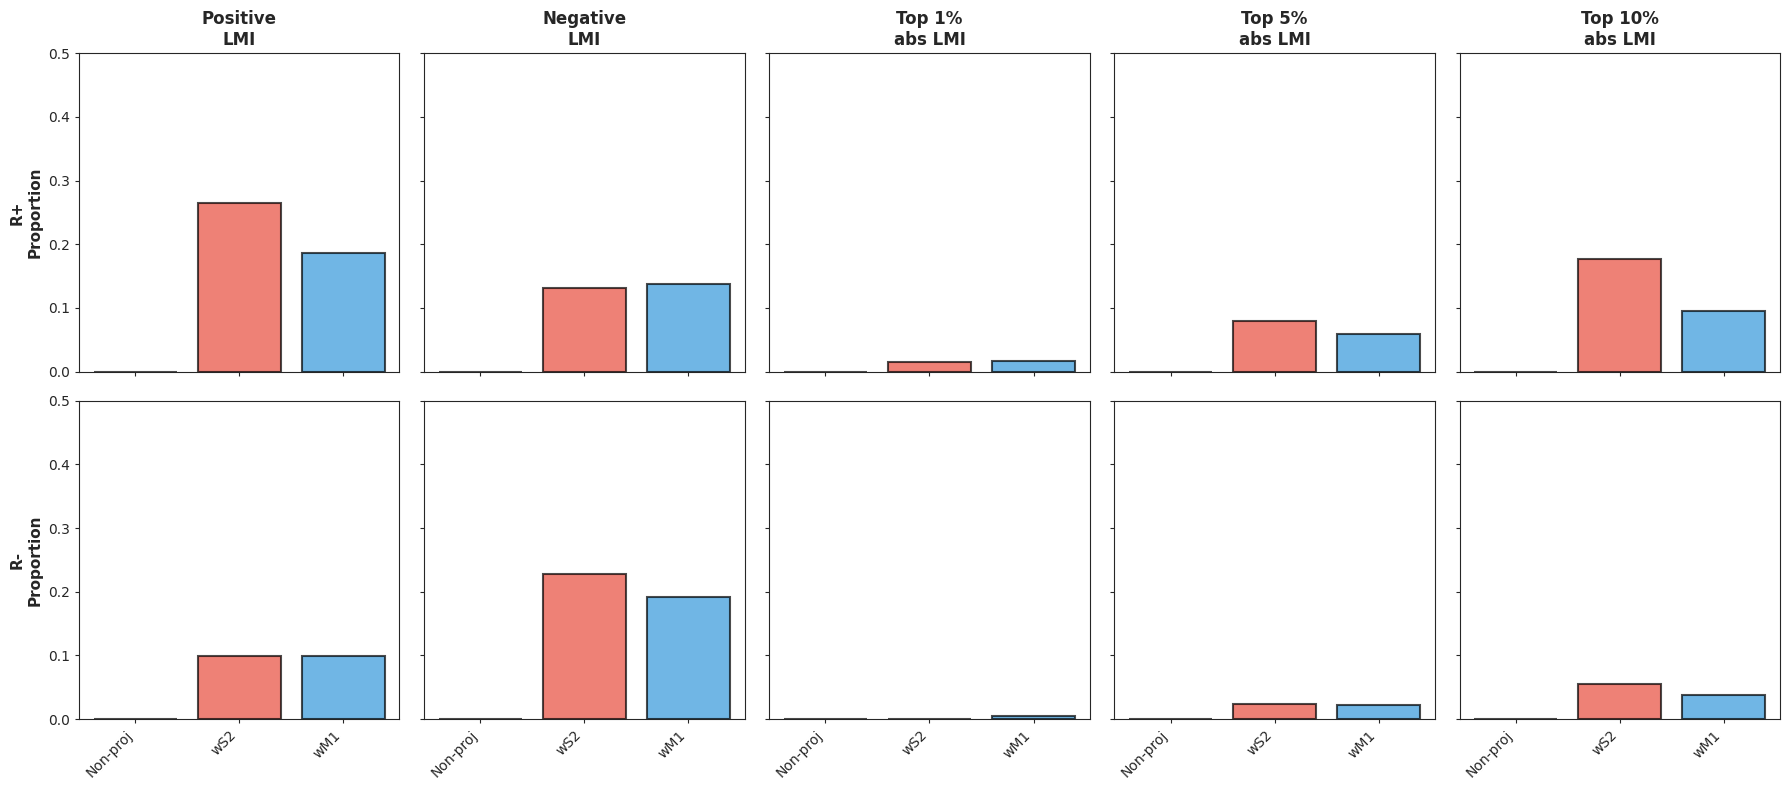

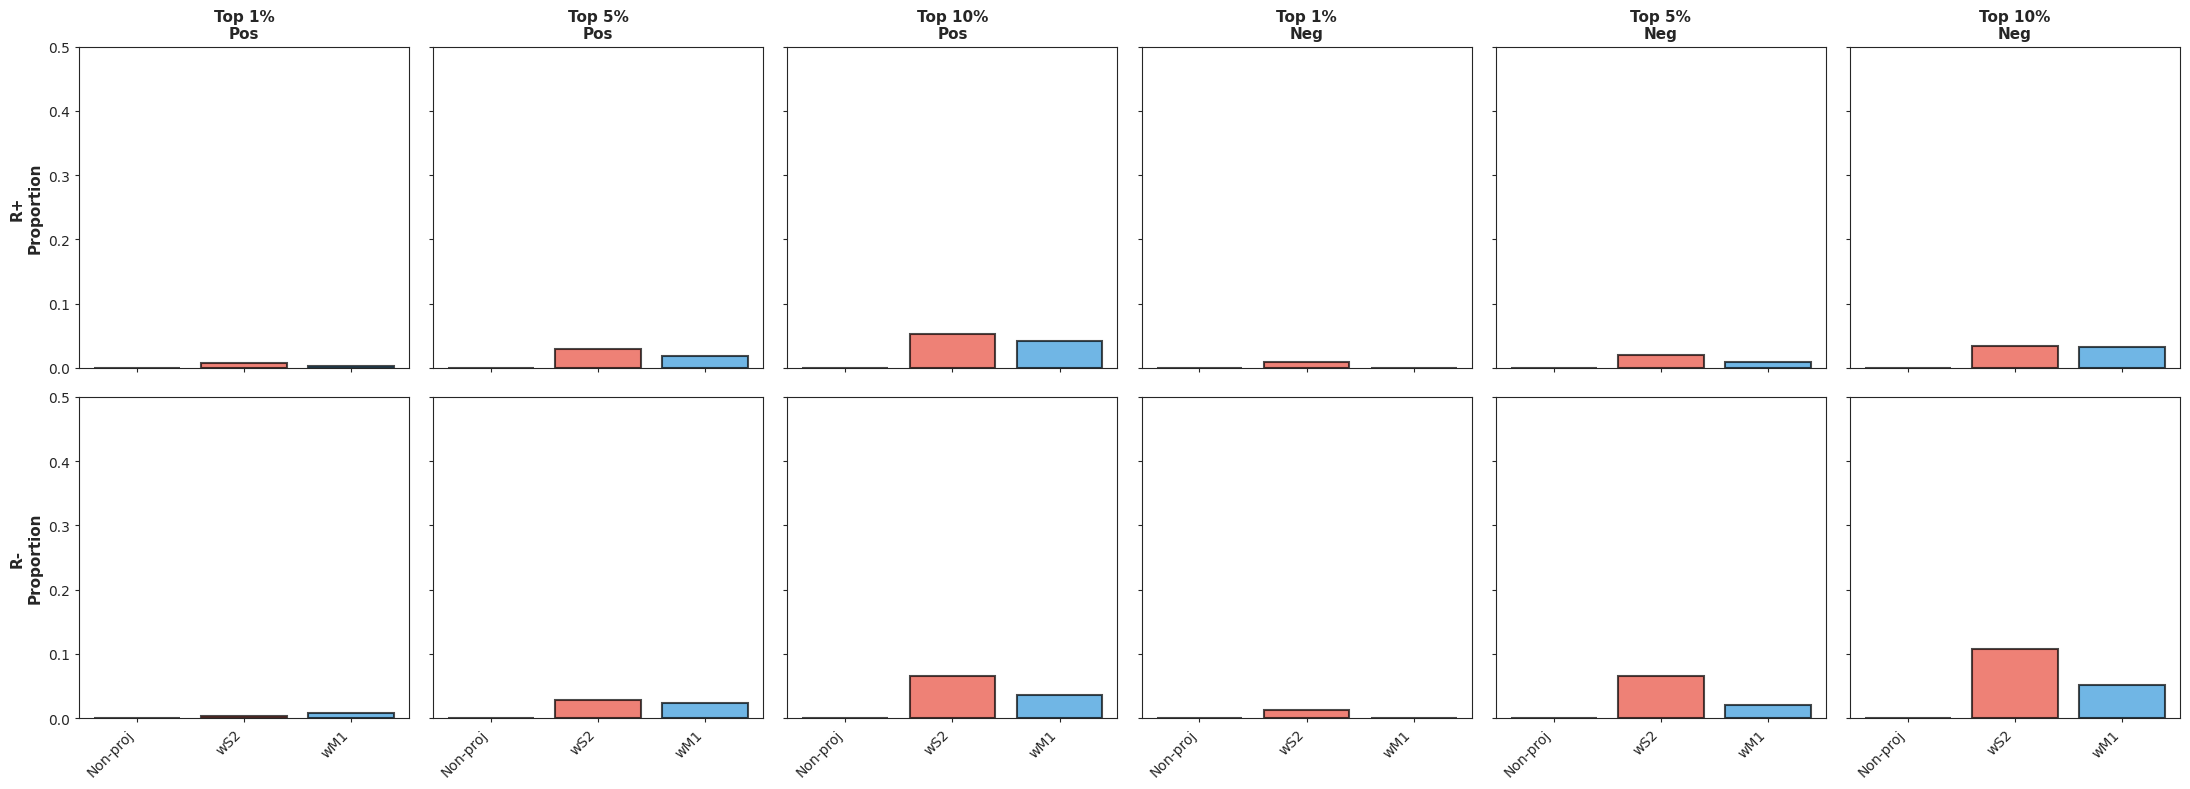

In [ ]:
print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

cell_types = ['non_projector', 'wS2', 'wM1']
cell_type_colors = {
    'non_projector': '#808080',  # Gray
    'wS2': '#E74C3C',  # Red
    'wM1': '#3498DB'   # Blue
}

# =============================================================================
# PART 1: LMI ANALYSIS
# =============================================================================

print("\nPART 1: LMI ANALYSIS")
print("-" * 80)

# Load LMI data
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")

# Define cell type groups
lmi_df['cell_type_group'] = lmi_df['cell_type'].copy()
lmi_df.loc[lmi_df['cell_type'].isna(), 'cell_type_group'] = 'non_projector'
lmi_df.loc[lmi_df['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
lmi_df.loc[lmi_df['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'
lmi_df = lmi_df[lmi_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {lmi_df['cell_type_group'].value_counts().to_dict()}")

# Define LMI criteria
lmi_df['positive_lmi'] = lmi_df['lmi_p'] >= 0.975
lmi_df['negative_lmi'] = lmi_df['lmi_p'] <= 0.025
abs_lmi = np.abs(lmi_df['lmi'])
lmi_df['top_1pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 99)
lmi_df['top_5pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 95)
lmi_df['top_10pct_abs_lmi'] = abs_lmi >= np.percentile(abs_lmi, 90)

# Compute proportions
lmi_criteria = ['positive_lmi', 'negative_lmi', 'top_1pct_abs_lmi', 'top_5pct_abs_lmi', 'top_10pct_abs_lmi']
lmi_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = lmi_df[(lmi_df['reward_group'] == reward_group) & (lmi_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in lmi_criteria:
            n_met = subset[criterion].sum()
            lmi_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_lmi_props = pd.DataFrame(lmi_proportions)
df_lmi_props.to_csv(os.path.join(output_dir, 'lmi_proportions.csv'), index=False)
print("Saved: lmi_proportions.csv")

# =============================================================================
# PART 2: CLASSIFIER WEIGHTS ANALYSIS
# =============================================================================

print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[weights_df['cell_type_xr'].isna(), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions.csv'), index=False)
print("Saved: weight_proportions.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")
print("-" * 80)

# Figure 1: LMI Proportions
lmi_labels = ['Positive\nLMI', 'Negative\nLMI', 'Top 1%\nabs LMI', 'Top 5%\nabs LMI', 'Top 10%\nabs LMI']
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_lmi_props[(df_lmi_props['reward_group'] == reward_group) &
                                  (df_lmi_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=12, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("Saved: figure_lmi_proportions.svg")

# Figure 2: Weight Proportions
weight_labels = ['Top 1%\nPos', 'Top 5%\nPos', 'Top 10%\nPos',
                  'Top 1%\nNeg', 'Top 5%\nNeg', 'Top 10%\nNeg']
fig, axes = plt.subplots(2, 6, figsize=(22, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_weight_props[(df_weight_props['reward_group'] == reward_group) &
                                     (df_weight_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Non-proj', 'wS2', 'wM1'], rotation=45, ha='right')
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=11, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("Saved: figure_weight_proportions.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")

In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# Simplified: analyze LMI and weights independently (no merge, no statistics).
# #############################################################################


print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

cell_types = ['non_projector', 'wS2', 'wM1']
cell_type_colors = {
    'non_projector': cell_types_palette[0],
    'wS2': cell_types_palette[1],
    'wM1': cell_types_palette[2],
}

# =============================================================================
# PART 1: LMI ANALYSIS
# =============================================================================

print("\nPART 1: LMI ANALYSIS")
print("-" * 80)

# Load LMI data
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")

# Define cell type groups (non-projectors are labeled 'na' in cell_type column)
lmi_df['cell_type_group'] = lmi_df['cell_type'].copy()
lmi_df.loc[lmi_df['cell_type'] == 'na', 'cell_type_group'] = 'non_projector'
lmi_df.loc[lmi_df['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
lmi_df.loc[lmi_df['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'
lmi_df = lmi_df[lmi_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {lmi_df['cell_type_group'].value_counts().to_dict()}")

# Define LMI criteria
# Significant LMI (positive and negative)
lmi_df['significant_pos_lmi'] = lmi_df['lmi_p'] >= 0.975
lmi_df['significant_neg_lmi'] = lmi_df['lmi_p'] <= 0.025

# Top percentiles for positive and negative LMI separately
pos_lmi = lmi_df[lmi_df['lmi'] > 0]['lmi']
neg_lmi = lmi_df[lmi_df['lmi'] < 0]['lmi']

lmi_df['top_1pct_pos_lmi'] = False
lmi_df['top_5pct_pos_lmi'] = False
lmi_df['top_10pct_pos_lmi'] = False
lmi_df['top_20pct_pos_lmi'] = False
lmi_df['top_1pct_neg_lmi'] = False
lmi_df['top_5pct_neg_lmi'] = False
lmi_df['top_10pct_neg_lmi'] = False
lmi_df['top_20pct_neg_lmi'] = False

if len(pos_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_1pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 99)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_5pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 95)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_10pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 90)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_20pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 80)

if len(neg_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_1pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 1)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_5pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 5)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_10pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 10)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_20pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 20)

# Compute proportions
lmi_criteria = [
    'significant_pos_lmi', 'significant_neg_lmi',
    'top_1pct_pos_lmi', 'top_5pct_pos_lmi', 'top_10pct_pos_lmi', 'top_20pct_pos_lmi',
    'top_1pct_neg_lmi', 'top_5pct_neg_lmi', 'top_10pct_neg_lmi', 'top_20pct_neg_lmi'
]
lmi_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = lmi_df[(lmi_df['reward_group'] == reward_group) & (lmi_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in lmi_criteria:
            n_met = subset[criterion].sum()
            lmi_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_lmi_props = pd.DataFrame(lmi_proportions)
df_lmi_props.to_csv(os.path.join(output_dir, 'lmi_proportions.csv'), index=False)
print("Saved: lmi_proportions.csv")

# =============================================================================
# PART 2: CLASSIFIER WEIGHTS ANALYSIS
# =============================================================================

print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups (non-projectors are labeled 'na' in xarray or NaN)
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[(weights_df['cell_type_xr'].isna()) | (weights_df['cell_type_xr'] == 'na'), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_20pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False
weights_df['top_20pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_20pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 80)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_20pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 20)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight', 'top_20pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight', 'top_20pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions.csv'), index=False)
print("Saved: weight_proportions.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")
print("-" * 80)

# Figure 1: LMI Proportions
lmi_labels = [
    'Sig.\nPos LMI', 'Sig.\nNeg LMI',
    'Top 1%\nPos LMI', 'Top 5%\nPos LMI', 'Top 10%\nPos LMI', 'Top 20%\nPos LMI',
    'Top 1%\nNeg LMI', 'Top 5%\nNeg LMI', 'Top 10%\nNeg LMI', 'Top 20%\nNeg LMI'
]
fig, axes = plt.subplots(2, 10, figsize=(28, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_lmi_props[(df_lmi_props['reward_group'] == reward_group) &
                                  (df_lmi_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['NP', 'S2', 'M1'], rotation=45, ha='right', fontsize=8)
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: figure_lmi_proportions.svg")

# Figure 2: Weight Proportions
weight_labels = [
    'Top 1%\nPos', 'Top 5%\nPos', 'Top 10%\nPos', 'Top 20%\nPos',
    'Top 1%\nNeg', 'Top 5%\nNeg', 'Top 10%\nNeg', 'Top 20%\nNeg'
]
fig, axes = plt.subplots(2, 8, figsize=(24, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_weight_props[(df_weight_props['reward_group'] == reward_group) &
                                     (df_weight_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['NP', 'S2', 'M1'], rotation=45, ha='right', fontsize=8)
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: figure_weight_proportions.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS


PART 1: LMI ANALYSIS
--------------------------------------------------------------------------------
LMI data: 6060 cells from 35 mice
Cell types: {'non_projector': 4989, 'wS2': 582, 'wM1': 489}
Saved: lmi_proportions.csv

PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF311/tensor_xarr


PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF311/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF313/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF314/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mn

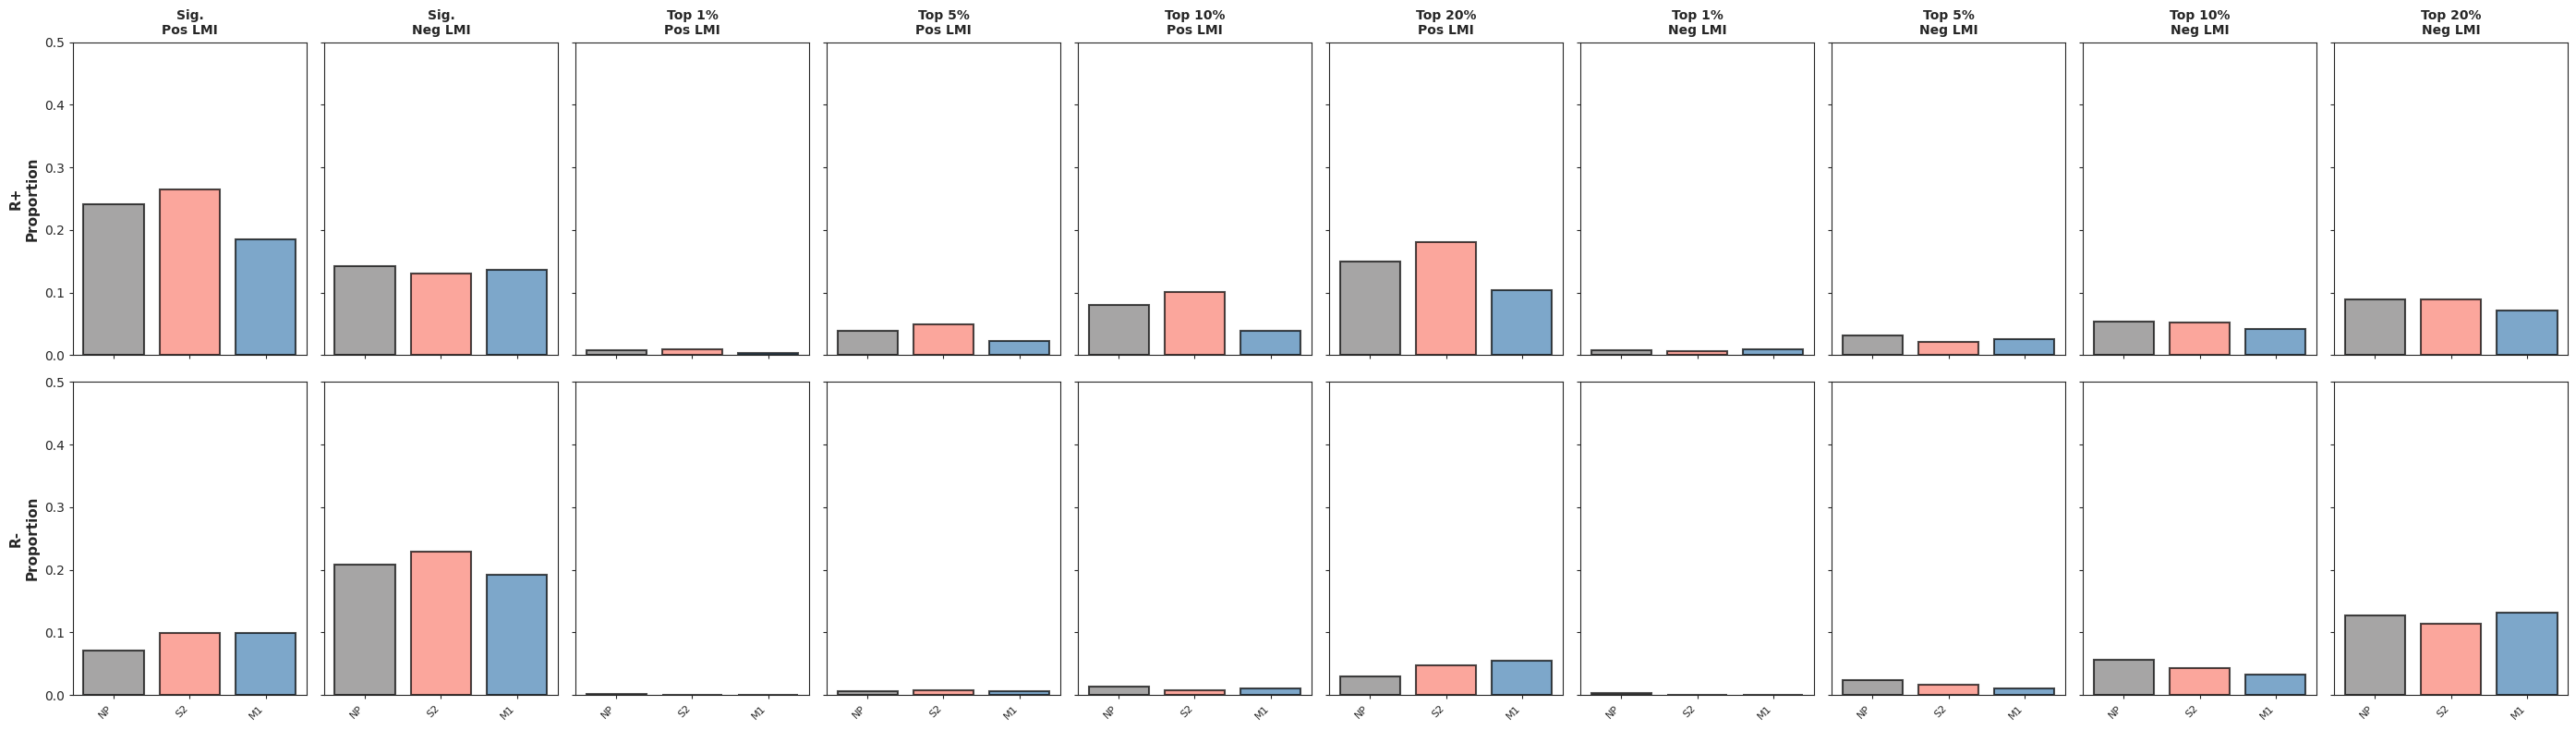

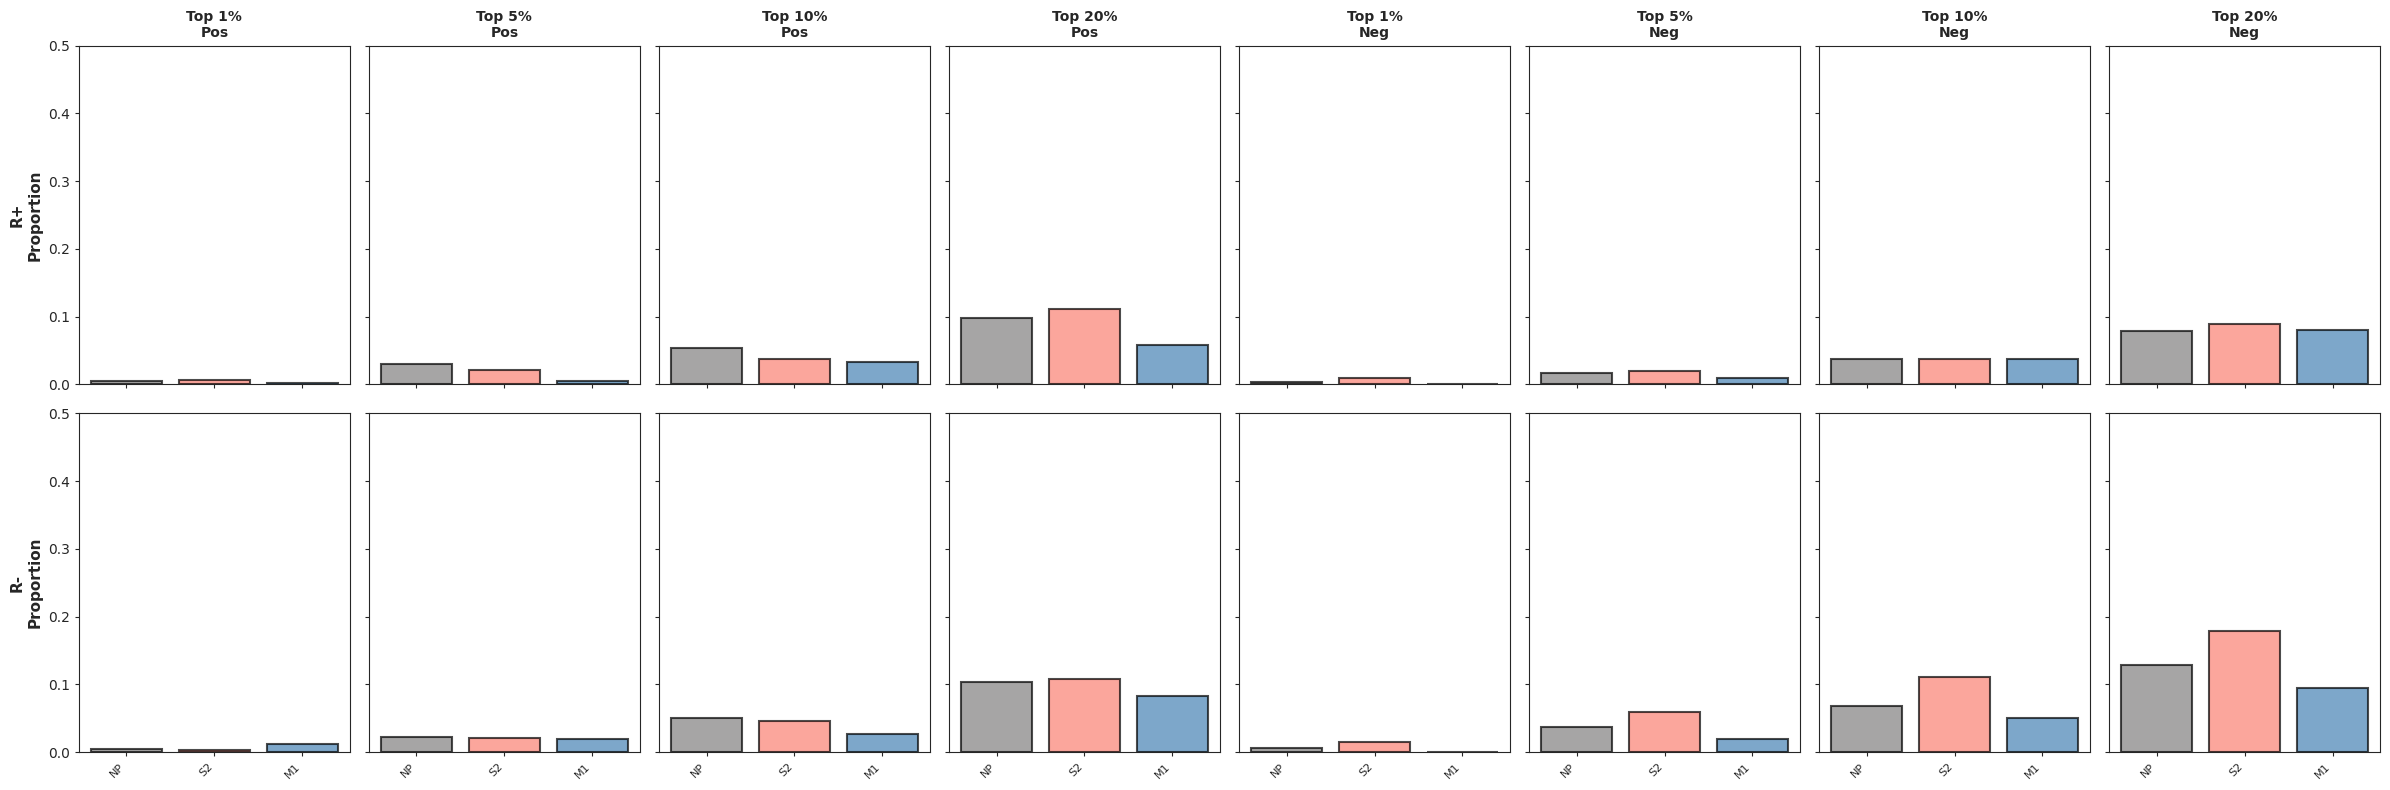

In [ ]:
print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups (non-projectors are labeled 'na' in xarray or NaN)
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[(weights_df['cell_type_xr'].isna()) | (weights_df['cell_type_xr'] == 'na'), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_20pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False
weights_df['top_20pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_20pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 80)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_20pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 20)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight', 'top_20pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight', 'top_20pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions.csv'), index=False)
print("Saved: weight_proportions.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")
print("-" * 80)

# Figure 1: LMI Proportions
lmi_labels = [
    'Sig.\nPos LMI', 'Sig.\nNeg LMI',
    'Top 1%\nPos LMI', 'Top 5%\nPos LMI', 'Top 10%\nPos LMI', 'Top 20%\nPos LMI',
    'Top 1%\nNeg LMI', 'Top 5%\nNeg LMI', 'Top 10%\nNeg LMI', 'Top 20%\nNeg LMI'
]
fig, axes = plt.subplots(2, 10, figsize=(28, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_lmi_props[(df_lmi_props['reward_group'] == reward_group) &
                                  (df_lmi_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['NP', 'S2', 'M1'], rotation=45, ha='right', fontsize=8)
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("Saved: figure_lmi_proportions.svg")

# Figure 2: Weight Proportions
weight_labels = [
    'Top 1%\nPos', 'Top 5%\nPos', 'Top 10%\nPos', 'Top 20%\nPos',
    'Top 1%\nNeg', 'Top 5%\nNeg', 'Top 10%\nNeg', 'Top 20%\nNeg'
]
fig, axes = plt.subplots(2, 8, figsize=(24, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_weight_props[(df_weight_props['reward_group'] == reward_group) &
                                     (df_weight_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['NP', 'S2', 'M1'], rotation=45, ha='right', fontsize=8)
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("Saved: figure_weight_proportions.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS


PART 1: LMI ANALYSIS
--------------------------------------------------------------------------------
LMI data: 6060 cells from 35 mice
Cell types: {'wS2': 582, 'wM1': 489}
Saved: lmi_proportions_within.csv
Saved: lmi_proportions_composition.csv

PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

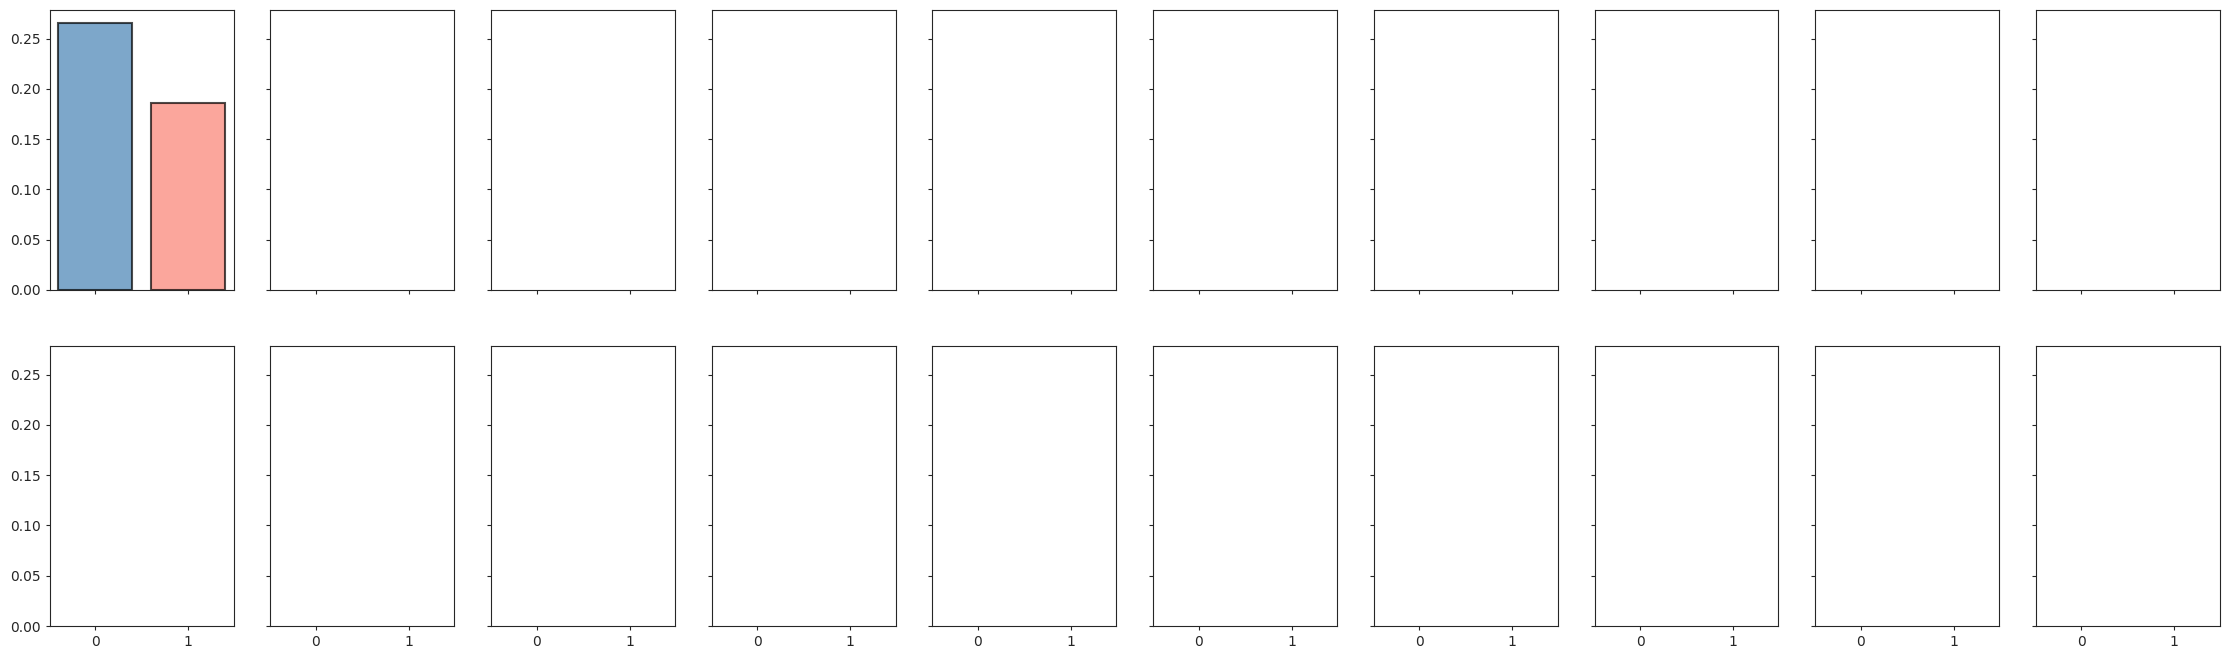

In [ ]:
print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Only analyze projection neurons (wS2 and wM1)
cell_types = ['wS2', 'wM1']
cell_type_colors = {
    'wS2': s2_m1_palette[0],
    'wM1': s2_m1_palette[1],
}

# =============================================================================
# PART 1: LMI ANALYSIS
# =============================================================================

print("\nPART 1: LMI ANALYSIS")
print("-" * 80)

# Load LMI data
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")

# Define cell type groups (non-projectors are labeled 'na' in cell_type column)
lmi_df['cell_type_group'] = lmi_df['cell_type'].copy()
lmi_df.loc[lmi_df['cell_type'] == 'na', 'cell_type_group'] = 'non_projector'
lmi_df.loc[lmi_df['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
lmi_df.loc[lmi_df['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'
lmi_df = lmi_df[lmi_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {lmi_df['cell_type_group'].value_counts().to_dict()}")

# Define LMI criteria
# Significant LMI (positive and negative)
lmi_df['significant_pos_lmi'] = lmi_df['lmi_p'] >= 0.975
lmi_df['significant_neg_lmi'] = lmi_df['lmi_p'] <= 0.025

# Top percentiles for positive and negative LMI separately
pos_lmi = lmi_df[lmi_df['lmi'] > 0]['lmi']
neg_lmi = lmi_df[lmi_df['lmi'] < 0]['lmi']

lmi_df['top_1pct_pos_lmi'] = False
lmi_df['top_5pct_pos_lmi'] = False
lmi_df['top_10pct_pos_lmi'] = False
lmi_df['top_20pct_pos_lmi'] = False
lmi_df['top_1pct_neg_lmi'] = False
lmi_df['top_5pct_neg_lmi'] = False
lmi_df['top_10pct_neg_lmi'] = False
lmi_df['top_20pct_neg_lmi'] = False

if len(pos_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_1pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 99)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_5pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 95)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_10pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 90)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_20pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 80)

if len(neg_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_1pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 1)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_5pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 5)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_10pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 10)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_20pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 20)

# Compute proportions
lmi_criteria = [
    'significant_pos_lmi', 'significant_neg_lmi',
    'top_1pct_pos_lmi', 'top_5pct_pos_lmi', 'top_10pct_pos_lmi', 'top_20pct_pos_lmi',
    'top_1pct_neg_lmi', 'top_5pct_neg_lmi', 'top_10pct_neg_lmi', 'top_20pct_neg_lmi'
]
lmi_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = lmi_df[(lmi_df['reward_group'] == reward_group) & (lmi_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in lmi_criteria:
            n_met = subset[criterion].sum()
            lmi_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_lmi_props = pd.DataFrame(lmi_proportions)
df_lmi_props.to_csv(os.path.join(output_dir, 'lmi_proportions_within.csv'), index=False)
print("Saved: lmi_proportions_within.csv")

# Compute composition perspective: "Of top X% cells, what % are wS2 vs wM1?"
lmi_composition = []

for reward_group in ['R+', 'R-']:
    data_rg = lmi_df[lmi_df['reward_group'] == reward_group]

    for criterion in lmi_criteria:
        # Get cells that meet this criterion
        top_cells = data_rg[data_rg[criterion] == True]
        n_top_total = len(top_cells)

        for cell_type in cell_types:
            n_this_type = len(top_cells[top_cells['cell_type_group'] == cell_type])
            lmi_composition.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_top_total': n_top_total,
                'n_this_type': n_this_type,
                'proportion': n_this_type / n_top_total if n_top_total > 0 else 0
            })

df_lmi_comp = pd.DataFrame(lmi_composition)
df_lmi_comp.to_csv(os.path.join(output_dir, 'lmi_proportions_composition.csv'), index=False)
print("Saved: lmi_proportions_composition.csv")

# =============================================================================
# PART 2: CLASSIFIER WEIGHTS ANALYSIS
# =============================================================================

print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups (non-projectors are labeled 'na' in xarray or NaN)
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[(weights_df['cell_type_xr'].isna()) | (weights_df['cell_type_xr'] == 'na'), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_20pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False
weights_df['top_20pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_20pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 80)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_20pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 20)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight', 'top_20pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight', 'top_20pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions_within.csv'), index=False)
print("Saved: weight_proportions_within.csv")

# Compute composition perspective: "Of top X% cells, what % are wS2 vs wM1?"
weight_composition = []

for reward_group in ['R+', 'R-']:
    data_rg = weights_df[weights_df['reward_group'] == reward_group]

    for criterion in weight_criteria:
        # Get cells that meet this criterion
        top_cells = data_rg[data_rg[criterion] == True]
        n_top_total = len(top_cells)

        for cell_type in cell_types:
            n_this_type = len(top_cells[top_cells['cell_type_group'] == cell_type])
            weight_composition.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_top_total': n_top_total,
                'n_this_type': n_this_type,
                'proportion': n_this_type / n_top_total if n_top_total > 0 else 0
            })

df_weight_comp = pd.DataFrame(weight_composition)
df_weight_comp.to_csv(os.path.join(output_dir, 'weight_proportions_composition.csv'), index=False)
print("Saved: weight_proportions_composition.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")
print("-" * 80)

# Figure 1: LMI Proportions
lmi_labels = [
    'Sig.\nPos LMI', 'Sig.\nNeg LMI',
    'Top 1%\nPos LMI', 'Top 5%\nPos LMI', 'Top 10%\nPos LMI', 'Top 20%\nPos LMI',
    'Top 1%\nNeg LMI', 'Top 5%\nNeg LMI', 'Top 10%\nNeg LMI', 'Top 20%\nNeg LMI'
]
fig, axes = plt.subplots(2, 10, figsize=(28, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(lmi_criteria, lmi_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_lmi_props[(df_lmi_props['reward_group'] == reward_group) &
                                  (df_lmi_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['NP', 'S2', 'M1'], rotation=45, ha='right', fontsize=8)
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_lmi_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("Saved: figure_lmi_proportions.svg")

# Figure 2: Weight Proportions
weight_labels = [
    'Top 1%\nPos', 'Top 5%\nPos', 'Top 10%\nPos', 'Top 20%\nPos',
    'Top 1%\nNeg', 'Top 5%\nNeg', 'Top 10%\nNeg', 'Top 20%\nNeg'
]
fig, axes = plt.subplots(2, 8, figsize=(24, 8), sharex=True, sharey=True)

for reward_idx, reward_group in enumerate(['R+', 'R-']):
    for crit_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[reward_idx, crit_idx]
        plot_data = df_weight_props[(df_weight_props['reward_group'] == reward_group) &
                                     (df_weight_props['criterion'] == criterion)]

        x_pos = np.arange(len(cell_types))
        proportions = [plot_data[plot_data['cell_type'] == ct]['proportion'].values[0]
                      if len(plot_data[plot_data['cell_type'] == ct]) > 0 else 0
                      for ct in cell_types]

        ax.bar(x_pos, proportions, color=[cell_type_colors[ct] for ct in cell_types],
               alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['NP', 'S2', 'M1'], rotation=45, ha='right', fontsize=8)
        ax.set_ylim(0, max(0.5, max(proportions) * 1.2) if max(proportions) > 0 else 0.1)

        if reward_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if crit_idx == 0:
            ax.set_ylabel(f'{reward_group}\nProportion', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_weight_proportions.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("Saved: figure_weight_proportions.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")

In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# Simplified: analyze LMI and weights independently (no merge, no statistics).
# #############################################################################


print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Only analyze projection neurons (wS2 and wM1)
cell_types = ['wS2', 'wM1']
cell_type_colors = {
    'wS2': s2_m1_palette[0],
    'wM1': s2_m1_palette[1],
}

# =============================================================================
# PART 1: LMI ANALYSIS
# =============================================================================

print("\nPART 1: LMI ANALYSIS")
print("-" * 80)

# Load LMI data
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")

# Define cell type groups (non-projectors are labeled 'na' in cell_type column)
lmi_df['cell_type_group'] = lmi_df['cell_type'].copy()
lmi_df.loc[lmi_df['cell_type'] == 'na', 'cell_type_group'] = 'non_projector'
lmi_df.loc[lmi_df['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
lmi_df.loc[lmi_df['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'
lmi_df = lmi_df[lmi_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {lmi_df['cell_type_group'].value_counts().to_dict()}")

# Define LMI criteria
# Significant LMI (positive and negative)
lmi_df['significant_pos_lmi'] = lmi_df['lmi_p'] >= 0.975
lmi_df['significant_neg_lmi'] = lmi_df['lmi_p'] <= 0.025

# Top percentiles for positive and negative LMI separately
pos_lmi = lmi_df[lmi_df['lmi'] > 0]['lmi']
neg_lmi = lmi_df[lmi_df['lmi'] < 0]['lmi']

lmi_df['top_1pct_pos_lmi'] = False
lmi_df['top_5pct_pos_lmi'] = False
lmi_df['top_10pct_pos_lmi'] = False
lmi_df['top_20pct_pos_lmi'] = False
lmi_df['top_1pct_neg_lmi'] = False
lmi_df['top_5pct_neg_lmi'] = False
lmi_df['top_10pct_neg_lmi'] = False
lmi_df['top_20pct_neg_lmi'] = False

if len(pos_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_1pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 99)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_5pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 95)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_10pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 90)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_20pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 80)

if len(neg_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_1pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 1)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_5pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 5)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_10pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 10)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_20pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 20)

# Compute proportions
lmi_criteria = [
    'significant_pos_lmi', 'significant_neg_lmi',
    'top_1pct_pos_lmi', 'top_5pct_pos_lmi', 'top_10pct_pos_lmi', 'top_20pct_pos_lmi',
    'top_1pct_neg_lmi', 'top_5pct_neg_lmi', 'top_10pct_neg_lmi', 'top_20pct_neg_lmi'
]
lmi_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = lmi_df[(lmi_df['reward_group'] == reward_group) & (lmi_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in lmi_criteria:
            n_met = subset[criterion].sum()
            lmi_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_lmi_props = pd.DataFrame(lmi_proportions)
df_lmi_props.to_csv(os.path.join(output_dir, 'lmi_proportions_within.csv'), index=False)
print("Saved: lmi_proportions_within.csv")

# Compute composition perspective: "Of top X% cells, what % are wS2 vs wM1?"
lmi_composition = []

for reward_group in ['R+', 'R-']:
    data_rg = lmi_df[lmi_df['reward_group'] == reward_group]

    for criterion in lmi_criteria:
        # Get cells that meet this criterion
        top_cells = data_rg[data_rg[criterion] == True]
        n_top_total = len(top_cells)

        for cell_type in cell_types:
            n_this_type = len(top_cells[top_cells['cell_type_group'] == cell_type])
            lmi_composition.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_top_total': n_top_total,
                'n_this_type': n_this_type,
                'proportion': n_this_type / n_top_total if n_top_total > 0 else 0
            })

df_lmi_comp = pd.DataFrame(lmi_composition)
df_lmi_comp.to_csv(os.path.join(output_dir, 'lmi_proportions_composition.csv'), index=False)
print("Saved: lmi_proportions_composition.csv")

# =============================================================================
# PART 2: CLASSIFIER WEIGHTS ANALYSIS
# =============================================================================

print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups (non-projectors are labeled 'na' in xarray or NaN)
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[(weights_df['cell_type_xr'].isna()) | (weights_df['cell_type_xr'] == 'na'), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_20pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False
weights_df['top_20pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_20pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 80)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_20pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 20)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight', 'top_20pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight', 'top_20pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions_within.csv'), index=False)
print("Saved: weight_proportions_within.csv")

# Compute composition perspective: "Of top X% cells, what % are wS2 vs wM1?"
weight_composition = []

for reward_group in ['R+', 'R-']:
    data_rg = weights_df[weights_df['reward_group'] == reward_group]

    for criterion in weight_criteria:
        # Get cells that meet this criterion
        top_cells = data_rg[data_rg[criterion] == True]
        n_top_total = len(top_cells)

        for cell_type in cell_types:
            n_this_type = len(top_cells[top_cells['cell_type_group'] == cell_type])
            weight_composition.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_top_total': n_top_total,
                'n_this_type': n_this_type,
                'proportion': n_this_type / n_top_total if n_top_total > 0 else 0
            })

df_weight_comp = pd.DataFrame(weight_composition)
df_weight_comp.to_csv(os.path.join(output_dir, 'weight_proportions_composition.csv'), index=False)
print("Saved: weight_proportions_composition.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")

# Separate LMI criteria into significant and percentile-based
lmi_sig_criteria = ['significant_pos_lmi', 'significant_neg_lmi']
lmi_pct_criteria = [
    'top_1pct_pos_lmi', 'top_5pct_pos_lmi', 'top_10pct_pos_lmi', 'top_20pct_pos_lmi',
    'top_1pct_neg_lmi', 'top_5pct_neg_lmi', 'top_10pct_neg_lmi', 'top_20pct_neg_lmi'
]

# ====================================================================================
# Figure 1: LMI Significant (Separate File)
# ====================================================================================
print("Creating Figure 1: LMI Significant...")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Proportion of wS2 and wM1 Neurons with Significant Learning-Modulated Activity',
             fontsize=14, fontweight='bold', y=0.98)

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, criterion in enumerate(lmi_sig_criteria):
        ax = axes[row_idx, col_idx]
        plot_data = df_lmi_props[
            (df_lmi_props['reward_group'] == reward_group) &
            (df_lmi_props['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 0.5)
        ax.set_title(f"{reward_group}: {'Positive' if 'pos' in criterion else 'Negative'} LMI",
                    fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_lmi_significant.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("  Saved: figure_lmi_significant.svg")

# ====================================================================================
# Figure 2: LMI Percentiles - Within Cell Type Perspective
# ====================================================================================
print("Creating Figure 2: LMI Percentiles (Within Cell Type)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Proportion of Each Projection Neuron Type in Top LMI Percentiles\n(Within Cell Type Perspective)',
             fontsize=14, fontweight='bold', y=0.98)

pct_labels = ['1%\nPos', '5%\nPos', '10%\nPos', '20%\nPos', '1%\nNeg', '5%\nNeg', '10%\nNeg', '20%\nNeg']

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(lmi_pct_criteria, pct_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_lmi_props[
            (df_lmi_props['reward_group'] == reward_group) &
            (df_lmi_props['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 0.5)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_lmi_percentile_within.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("  Saved: figure_lmi_percentile_within.svg")

# ====================================================================================
# Figure 3: LMI Percentiles - Composition Perspective
# ====================================================================================
print("Creating Figure 3: LMI Percentiles (Composition)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Cell Type Composition of Top LMI Percentiles\n(Of Top X%, what % are wS2 vs wM1)',
             fontsize=14, fontweight='bold', y=0.98)

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(lmi_pct_criteria, pct_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_lmi_comp[
            (df_lmi_comp['reward_group'] == reward_group) &
            (df_lmi_comp['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 1.0)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_lmi_percentile_composition.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("  Saved: figure_lmi_percentile_composition.svg")

# ====================================================================================
# Figure 4: Weight Percentiles - Within Cell Type Perspective
# ====================================================================================
print("Creating Figure 4: Weight Percentiles (Within Cell Type)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Proportion of Each Projection Neuron Type in Top Decoder Weight Percentiles\n(Within Cell Type Perspective)',
             fontsize=14, fontweight='bold', y=0.98)

weight_labels = ['1%\nPos', '5%\nPos', '10%\nPos', '20%\nPos', '1%\nNeg', '5%\nNeg', '10%\nNeg', '20%\nNeg']

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_weight_props[
            (df_weight_props['reward_group'] == reward_group) &
            (df_weight_props['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 0.5)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_weight_percentile_within.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("  Saved: figure_weight_percentile_within.svg")

# ====================================================================================
# Figure 5: Weight Percentiles - Composition Perspective
# ====================================================================================
print("Creating Figure 5: Weight Percentiles (Composition)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Cell Type Composition of Top Decoder Weight Percentiles\n(Of Top X%, what % are wS2 vs wM1)',
             fontsize=14, fontweight='bold', y=0.98)

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_weight_comp[
            (df_weight_comp['reward_group'] == reward_group) &
            (df_weight_comp['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 1.0)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_weight_percentile_composition.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("  Saved: figure_weight_percentile_composition.svg")

# ====================================================================================
# Figure 6: Cell Counts Summary
# ====================================================================================
print("Creating Figure 6: Cell Counts Summary...")

# Calculate total counts and per-mouse means
total_counts = []
per_mouse_counts = []

for cell_type in cell_types:
    # Total across all mice
    total_lmi = len(lmi_df[lmi_df['cell_type_group'] == cell_type])

    # Per-mouse mean and SEM
    counts_per_mouse = lmi_df[lmi_df['cell_type_group'] == cell_type].groupby('mouse_id').size()
    mean_per_mouse = counts_per_mouse.mean()
    sem_per_mouse = counts_per_mouse.sem()

    total_counts.append({'cell_type': cell_type, 'count': total_lmi})
    per_mouse_counts.append({
        'cell_type': cell_type,
        'mean': mean_per_mouse,
        'sem': sem_per_mouse
    })

df_total = pd.DataFrame(total_counts)
df_per_mouse = pd.DataFrame(per_mouse_counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Total and Per-Mouse Counts of Projection Neuron Types',
             fontsize=14, fontweight='bold')

# Left: Total counts
sns.barplot(data=df_total, x='cell_type', y='count',
           palette=[cell_type_colors[ct] for ct in cell_types],
           ax=ax1, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_title('Total Counts (All Mice)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cell Type', fontsize=11)
ax1.set_ylabel('Total Count', fontsize=11)

# Right: Mean per mouse with error bars
ax2.bar(range(len(cell_types)), df_per_mouse['mean'],
        yerr=df_per_mouse['sem'],
        color=[cell_type_colors[ct] for ct in cell_types],
        alpha=0.7, edgecolor='black', linewidth=1.5,
        error_kw={'linewidth': 2, 'ecolor': 'black', 'capsize': 5})
ax2.set_title('Mean Counts Per Mouse', fontsize=12, fontweight='bold')
ax2.set_xlabel('Cell Type', fontsize=11)
ax2.set_ylabel('Mean Count Per Mouse ± SEM', fontsize=11)
ax2.set_xticks(range(len(cell_types)))
ax2.set_xticklabels(cell_types)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_cell_counts.svg'), format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("  Saved: figure_cell_counts.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")
print("\nGenerated 6 figures:")
print("  1. figure_lmi_significant.svg")
print("  2. figure_lmi_percentile_within.svg")
print("  3. figure_lmi_percentile_composition.svg")
print("  4. figure_weight_percentile_within.svg")
print("  5. figure_weight_percentile_composition.svg")
print("  6. figure_cell_counts.svg")


PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS


PART 1: LMI ANALYSIS
--------------------------------------------------------------------------------
LMI data: 6060 cells from 35 mice
Cell types: {'wS2': 582, 'wM1': 489}
Saved: lmi_proportions_within.csv
Saved: lmi_proportions_composition.csv

PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed

<ipython-input-23-7f1145d165e8>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_lmi_significant.svg
Creating Figure 2: LMI Percentiles (Within Cell Type)...


<ipython-input-23-7f1145d165e8>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_lmi_percentile_within.svg
Creating Figure 3: LMI Percentiles (Composition)...


<ipython-input-23-7f1145d165e8>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_lmi_percentile_composition.svg
Creating Figure 4: Weight Percentiles (Within Cell Type)...


<ipython-input-23-7f1145d165e8>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_weight_percentile_within.svg
Creating Figure 5: Weight Percentiles (Composition)...


<ipython-input-23-7f1145d165e8>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-23-7f1145d165e8>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_weight_percentile_composition.svg
Creating Figure 6: Cell Counts Summary...
  Saved: figure_cell_counts.svg

ANALYSIS COMPLETE
Outputs saved to: /mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions

Generated 6 figures:
  1. figure_lmi_significant.svg
  2. figure_lmi_percentile_within.svg
  3. figure_lmi_percentile_composition.svg
  4. figure_weight_percentile_within.svg
  5. figure_weight_percentile_composition.svg
  6. figure_cell_counts.svg


<ipython-input-23-7f1145d165e8>:484: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_total, x='cell_type', y='count',



PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS


PART 1: LMI ANALYSIS
--------------------------------------------------------------------------------
LMI data: 6060 cells from 35 mice
Cell types: {'wS2': 582, 'wM1': 489}
Saved: lmi_proportions_within.csv
Saved: lmi_proportions_composition.csv

PART 2: CLASSIFIER WEIGHTS ANALYSIS
--------------------------------------------------------------------------------
Weights data: 8780 cells from 34 mice
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF305/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF306/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF307/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed/mice/GF308/tensor_xarray_mapping_data_baselinesubstracted.nc
Loading /mnt/lsens-analysis/Anthony_Renard/data_processed

<ipython-input-24-192b03522bf0>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:292: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_lmi_significant.svg
Creating Figure 2: LMI Percentiles (Within Cell Type)...


<ipython-input-24-192b03522bf0>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_lmi_percentile_within.svg
Creating Figure 3: LMI Percentiles (Composition)...


<ipython-input-24-192b03522bf0>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_lmi_percentile_composition.svg
Creating Figure 4: Weight Percentiles (Within Cell Type)...


<ipython-input-24-192b03522bf0>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:398: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_weight_percentile_within.svg
Creating Figure 5: Weight Percentiles (Composition)...


<ipython-input-24-192b03522bf0>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='cell_type', y='proportion',
<ipython-input-24-192b03522bf0>:433: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

  Saved: figure_weight_percentile_composition.svg
Creating Figure 6: Cell Counts Summary...
  Saved: figure_cell_counts.svg

ANALYSIS COMPLETE
Outputs saved to: /mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions

Generated 6 figures:
  1. figure_lmi_significant.svg
  2. figure_lmi_percentile_within.svg
  3. figure_lmi_percentile_composition.svg
  4. figure_weight_percentile_within.svg
  5. figure_weight_percentile_composition.svg
  6. figure_cell_counts.svg


<ipython-input-24-192b03522bf0>:484: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_total, x='cell_type', y='count',


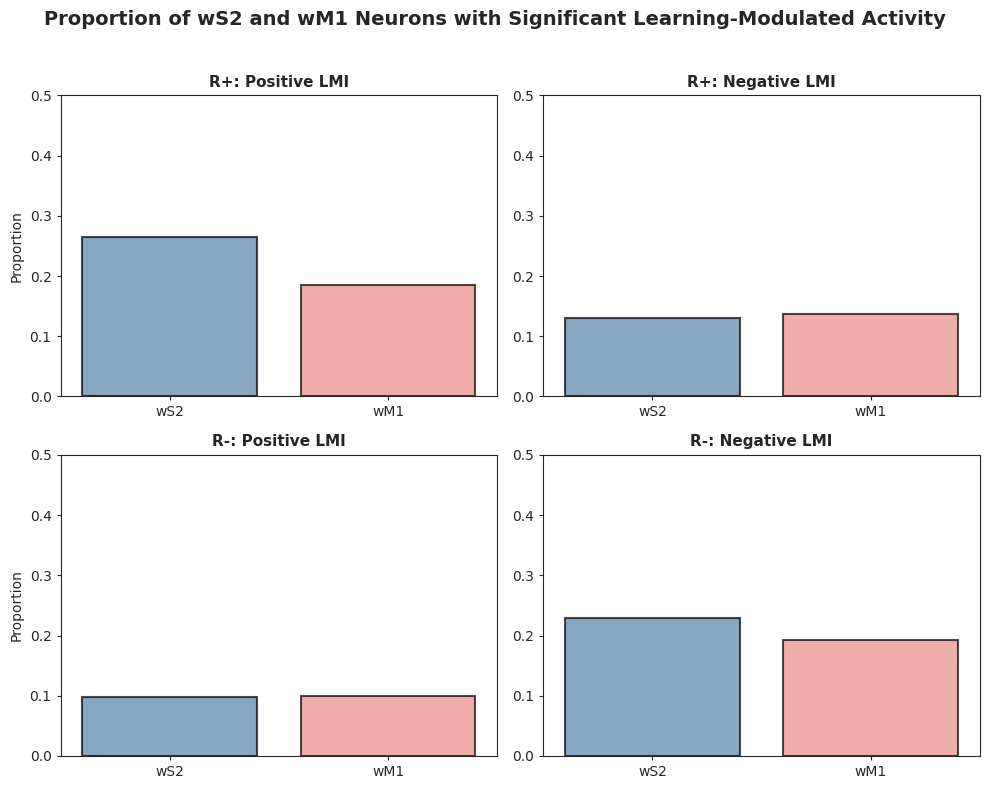

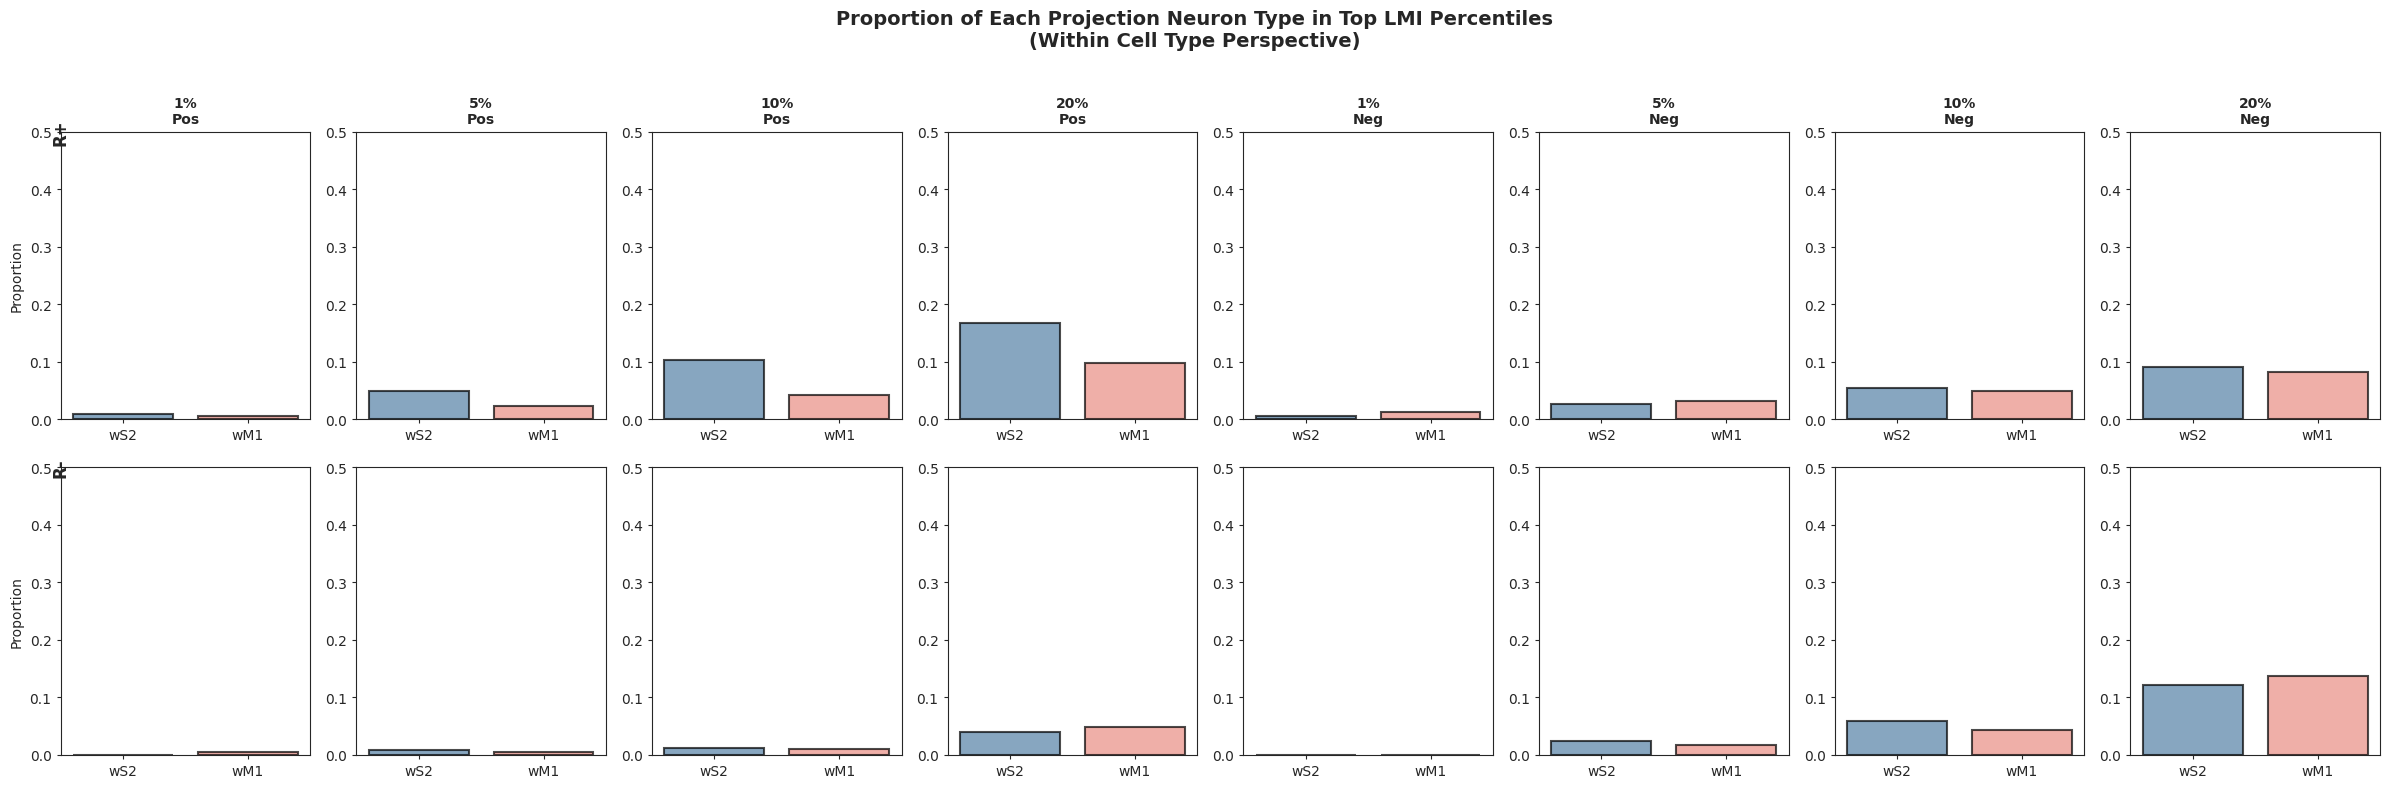

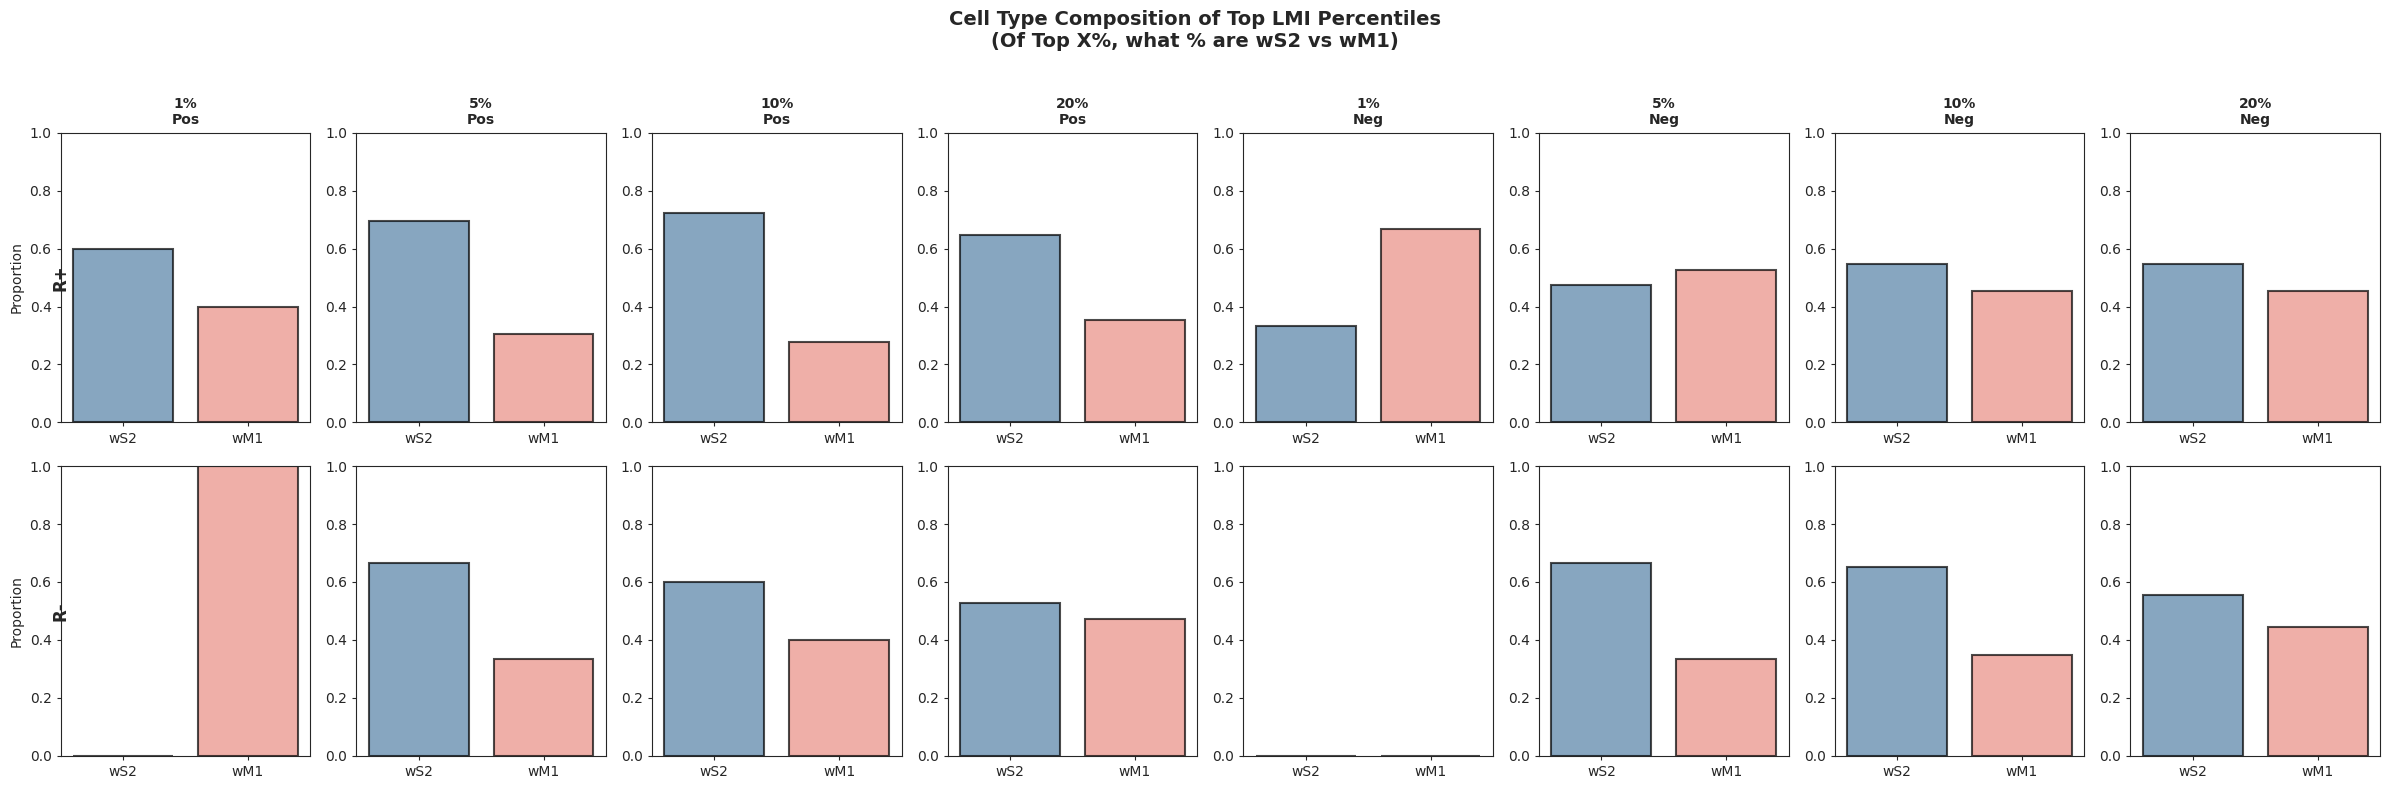

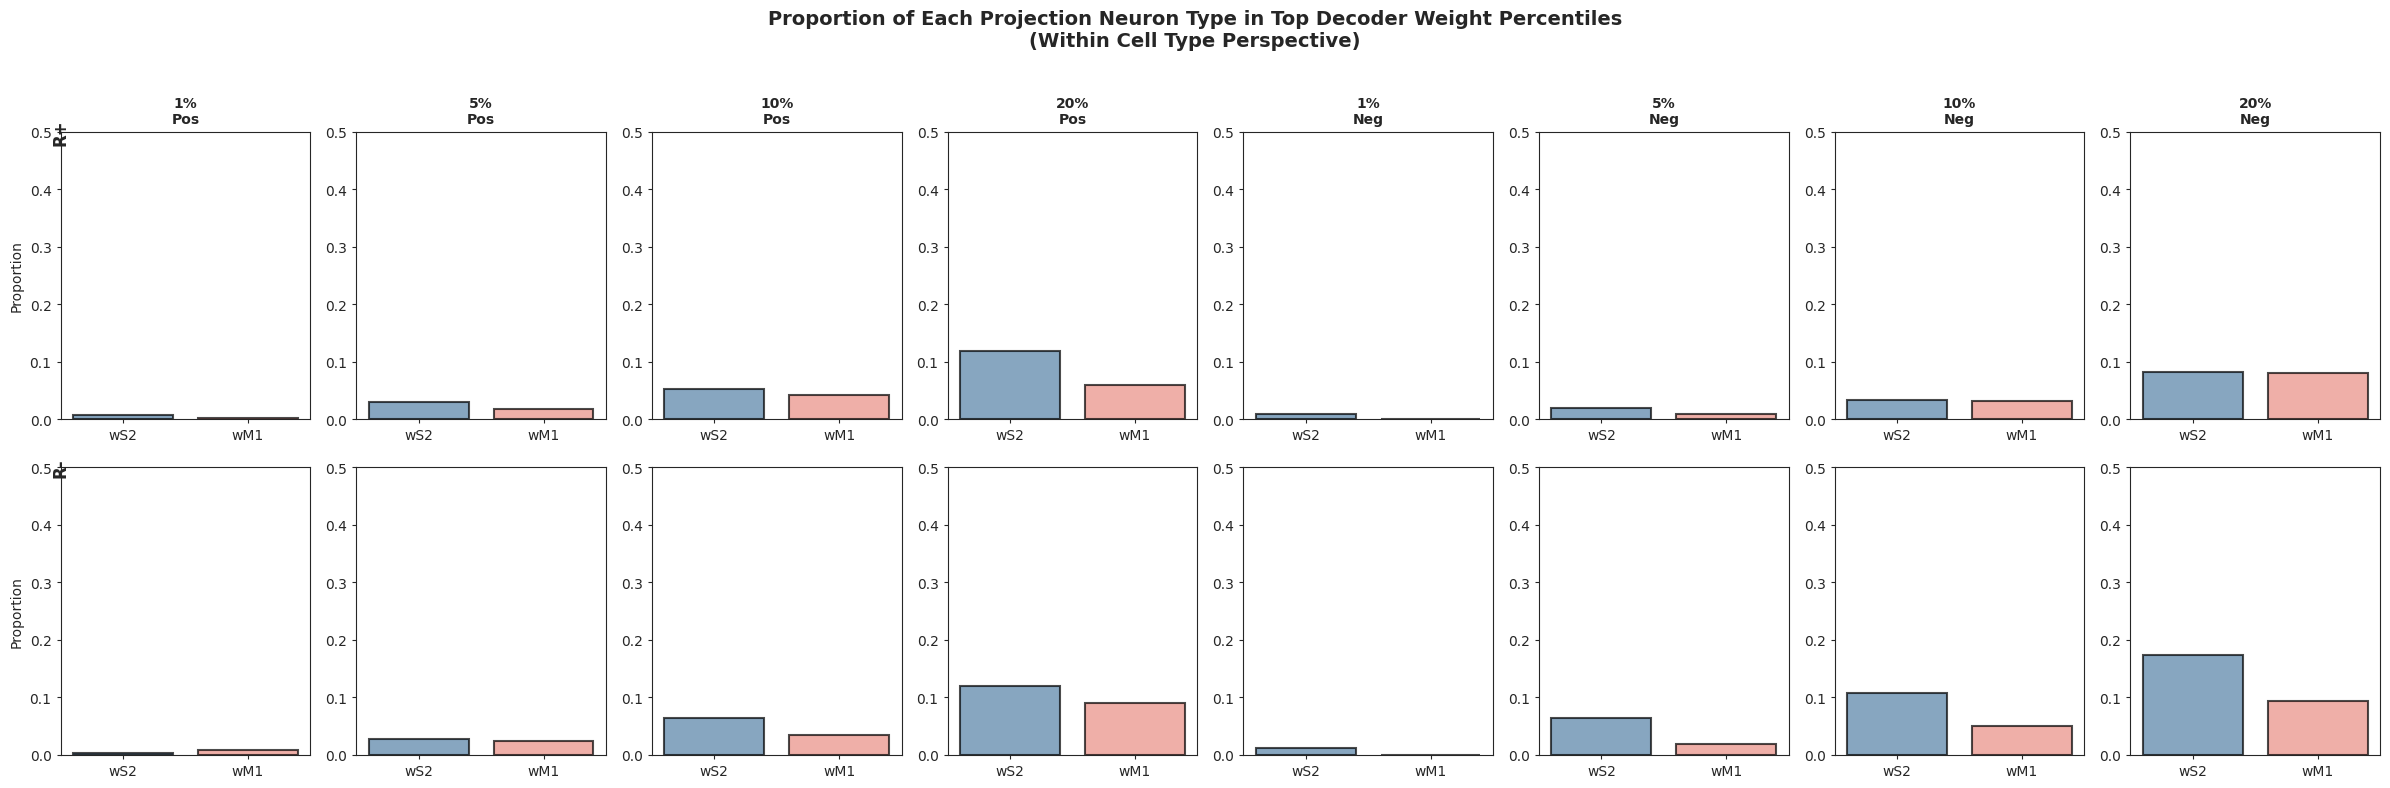

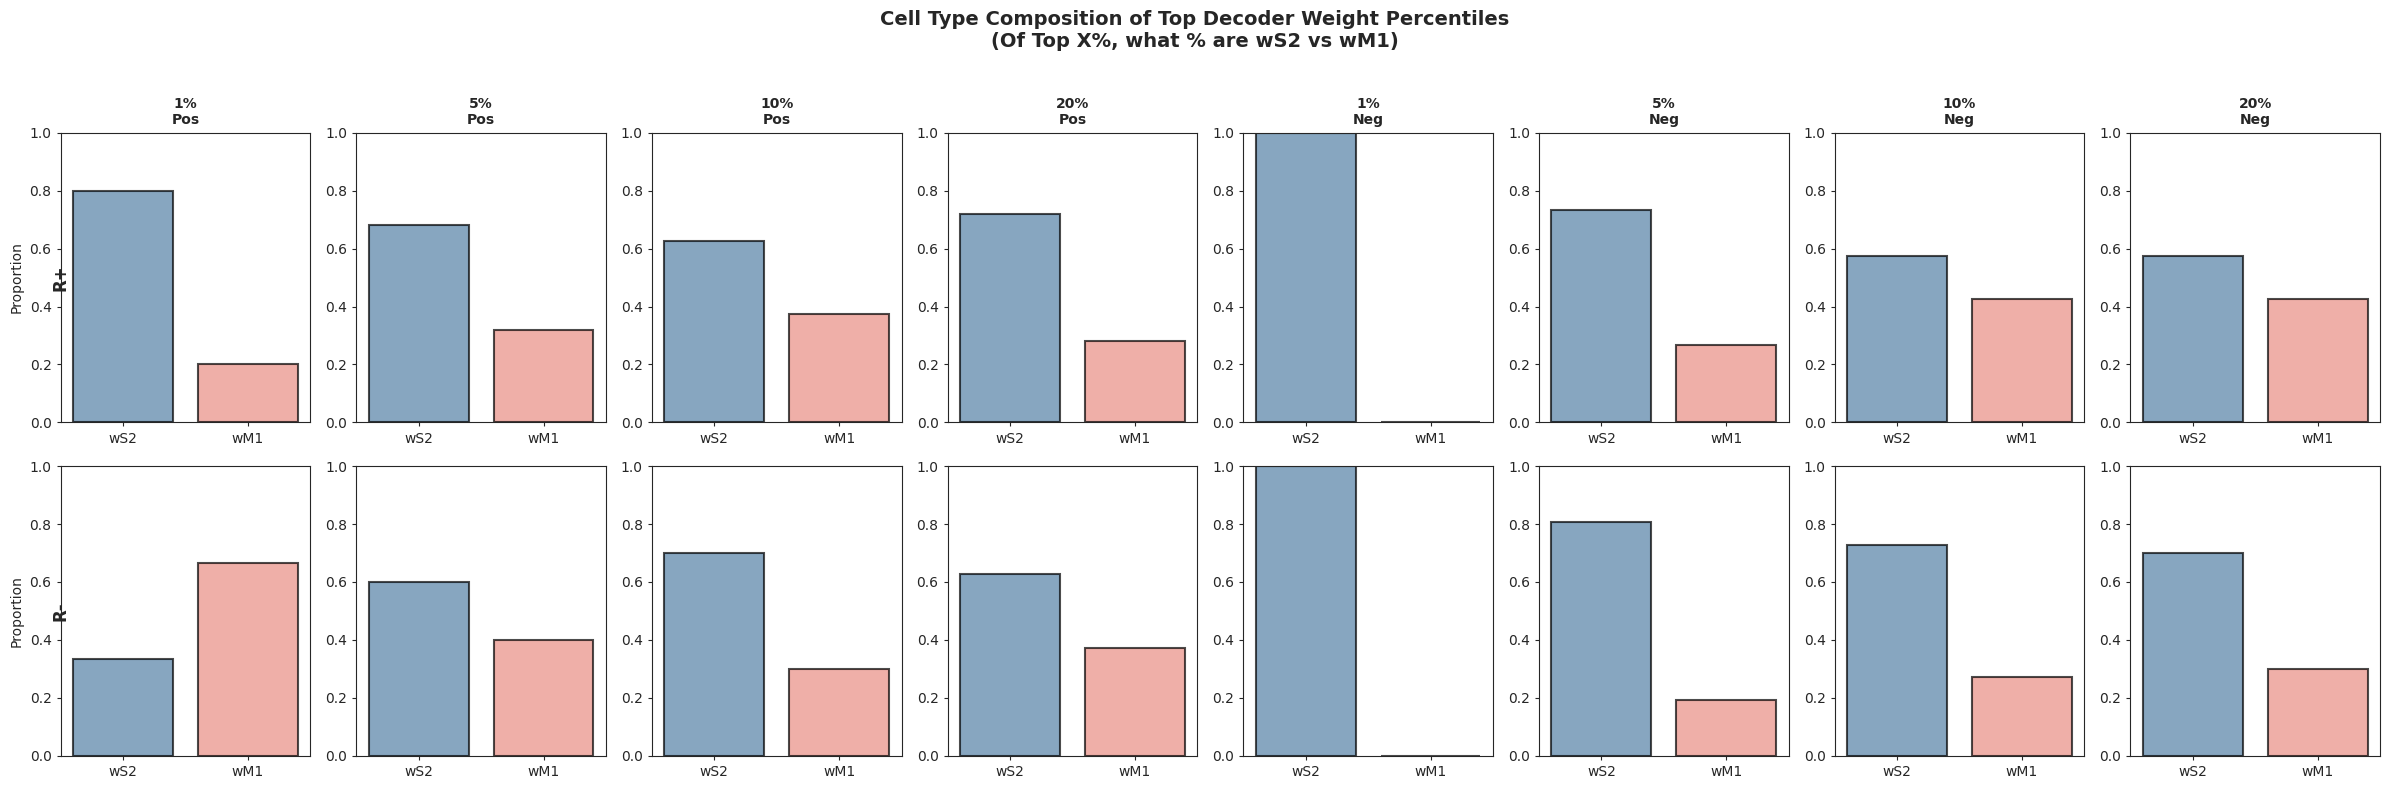

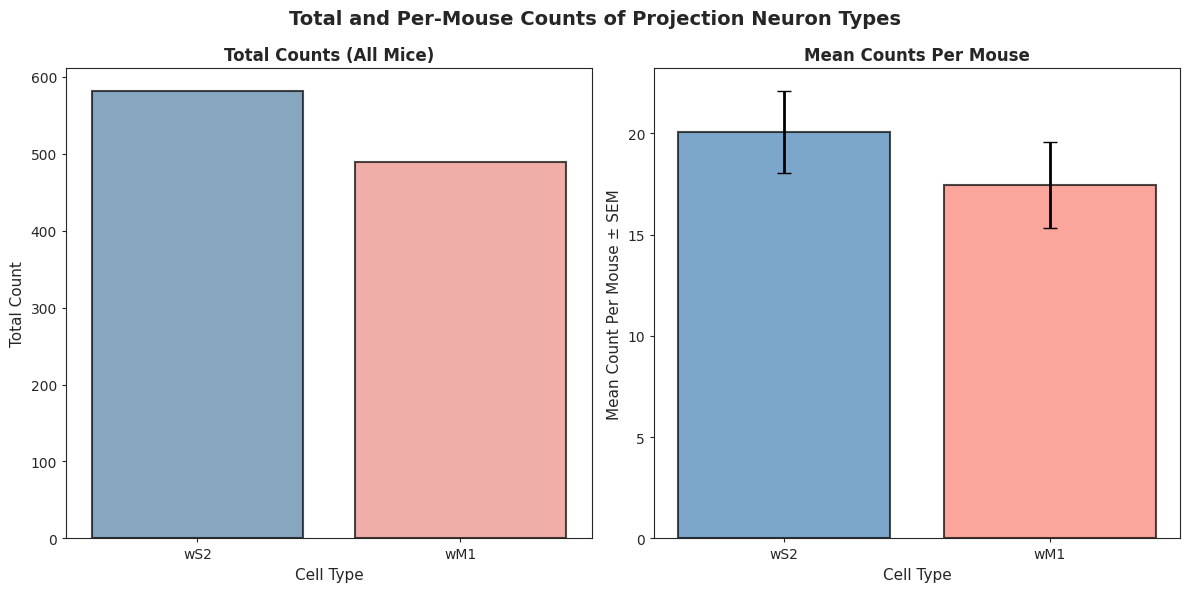

In [ ]:
# #############################################################################
# Contribution of projection neurons to LMI and classifier weights.
# Simplified: analyze LMI and weights independently (no merge, no statistics).
# #############################################################################


print("\n" + "="*80)
print("PROJECTION NEURON CONTRIBUTIONS TO LMI AND CLASSIFIER WEIGHTS")
print("="*80 + "\n")

# Output directory
output_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/projectors_contributions'
output_dir = io.adjust_path_to_host(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Only analyze projection neurons (wS2 and wM1)
cell_types = ['wS2', 'wM1']
cell_type_colors = {
    'wS2': s2_m1_palette[0],
    'wM1': s2_m1_palette[1],
}

# =============================================================================
# PART 1: LMI ANALYSIS
# =============================================================================

print("\nPART 1: LMI ANALYSIS")
print("-" * 80)

# Load LMI data
processed_folder = io.solve_common_paths('processed_data')
lmi_df = pd.read_csv(os.path.join(processed_folder, 'lmi_results.csv'))

# Add reward group
for mouse in lmi_df.mouse_id.unique():
    lmi_df.loc[lmi_df.mouse_id==mouse, 'reward_group'] = io.get_mouse_reward_group_from_db(io.db_path, mouse)

print(f"LMI data: {len(lmi_df)} cells from {lmi_df['mouse_id'].nunique()} mice")

# Define cell type groups (non-projectors are labeled 'na' in cell_type column)
lmi_df['cell_type_group'] = lmi_df['cell_type'].copy()
lmi_df.loc[lmi_df['cell_type'] == 'na', 'cell_type_group'] = 'non_projector'
lmi_df.loc[lmi_df['cell_type'] == 'wS2', 'cell_type_group'] = 'wS2'
lmi_df.loc[lmi_df['cell_type'] == 'wM1', 'cell_type_group'] = 'wM1'
lmi_df = lmi_df[lmi_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {lmi_df['cell_type_group'].value_counts().to_dict()}")

# Define LMI criteria
# Significant LMI (positive and negative)
lmi_df['significant_pos_lmi'] = lmi_df['lmi_p'] >= 0.975
lmi_df['significant_neg_lmi'] = lmi_df['lmi_p'] <= 0.025

# Top percentiles for positive and negative LMI separately
pos_lmi = lmi_df[lmi_df['lmi'] > 0]['lmi']
neg_lmi = lmi_df[lmi_df['lmi'] < 0]['lmi']

lmi_df['top_1pct_pos_lmi'] = False
lmi_df['top_5pct_pos_lmi'] = False
lmi_df['top_10pct_pos_lmi'] = False
lmi_df['top_20pct_pos_lmi'] = False
lmi_df['top_1pct_neg_lmi'] = False
lmi_df['top_5pct_neg_lmi'] = False
lmi_df['top_10pct_neg_lmi'] = False
lmi_df['top_20pct_neg_lmi'] = False

if len(pos_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_1pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 99)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_5pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 95)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_10pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 90)
    lmi_df.loc[lmi_df['lmi'] > 0, 'top_20pct_pos_lmi'] = lmi_df.loc[lmi_df['lmi'] > 0, 'lmi'] >= np.percentile(pos_lmi, 80)

if len(neg_lmi) > 0:
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_1pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 1)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_5pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 5)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_10pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 10)
    lmi_df.loc[lmi_df['lmi'] < 0, 'top_20pct_neg_lmi'] = lmi_df.loc[lmi_df['lmi'] < 0, 'lmi'] <= np.percentile(neg_lmi, 20)

# Compute proportions
lmi_criteria = [
    'significant_pos_lmi', 'significant_neg_lmi',
    'top_1pct_pos_lmi', 'top_5pct_pos_lmi', 'top_10pct_pos_lmi', 'top_20pct_pos_lmi',
    'top_1pct_neg_lmi', 'top_5pct_neg_lmi', 'top_10pct_neg_lmi', 'top_20pct_neg_lmi'
]
lmi_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = lmi_df[(lmi_df['reward_group'] == reward_group) & (lmi_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in lmi_criteria:
            n_met = subset[criterion].sum()
            lmi_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_lmi_props = pd.DataFrame(lmi_proportions)
df_lmi_props.to_csv(os.path.join(output_dir, 'lmi_proportions_within.csv'), index=False)
print("Saved: lmi_proportions_within.csv")

# Compute composition perspective: "Of top X% cells, what % are wS2 vs wM1?"
lmi_composition = []

for reward_group in ['R+', 'R-']:
    data_rg = lmi_df[lmi_df['reward_group'] == reward_group]

    for criterion in lmi_criteria:
        # Get cells that meet this criterion
        top_cells = data_rg[data_rg[criterion] == True]
        n_top_total = len(top_cells)

        for cell_type in cell_types:
            n_this_type = len(top_cells[top_cells['cell_type_group'] == cell_type])
            lmi_composition.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_top_total': n_top_total,
                'n_this_type': n_this_type,
                'proportion': n_this_type / n_top_total if n_top_total > 0 else 0
            })

df_lmi_comp = pd.DataFrame(lmi_composition)
df_lmi_comp.to_csv(os.path.join(output_dir, 'lmi_proportions_composition.csv'), index=False)
print("Saved: lmi_proportions_composition.csv")

# =============================================================================
# PART 2: CLASSIFIER WEIGHTS ANALYSIS
# =============================================================================

print("\nPART 2: CLASSIFIER WEIGHTS ANALYSIS")
print("-" * 80)

# Load weights
weights_dir = '/mnt/lsens-analysis/Anthony_Renard/analysis_output/fast-learning/decoding'
weights_dir = io.adjust_path_to_host(weights_dir)
weights_df = pd.read_csv(os.path.join(weights_dir, 'classifier_weights.csv'))

print(f"Weights data: {len(weights_df)} cells from {weights_df['mouse_id'].nunique()} mice")

# Load cell types from xarray
cell_type_info = []
for mouse_id in weights_df['mouse_id'].unique():
    try:
        data_xr = imaging_utils.load_mouse_xarray(
            mouse_id,
            os.path.join(io.processed_dir, 'mice'),
            'tensor_xarray_mapping_data.nc'
        )
        rois = data_xr.coords['roi'].values
        cts = data_xr.coords['cell_type'].values if 'cell_type' in data_xr.coords else [None] * len(rois)

        for roi, ct in zip(rois, cts):
            cell_type_info.append({'mouse_id': mouse_id, 'roi': roi, 'cell_type_xr': ct})
    except:
        pass

# Merge weights with cell types
weights_df = weights_df.merge(pd.DataFrame(cell_type_info), on=['mouse_id', 'roi'], how='left')

# Define cell type groups (non-projectors are labeled 'na' in xarray or NaN)
weights_df['cell_type_group'] = weights_df['cell_type_xr'].copy()
weights_df.loc[(weights_df['cell_type_xr'].isna()) | (weights_df['cell_type_xr'] == 'na'), 'cell_type_group'] = 'non_projector'
weights_df.loc[weights_df['cell_type_xr'] == 'wS2', 'cell_type_group'] = 'wS2'
weights_df.loc[weights_df['cell_type_xr'] == 'wM1', 'cell_type_group'] = 'wM1'
weights_df = weights_df[weights_df['cell_type_group'].isin(cell_types)]

print(f"Cell types: {weights_df['cell_type_group'].value_counts().to_dict()}")

# Define weight criteria
pos_weights = weights_df[weights_df['classifier_weight'] > 0]['classifier_weight']
neg_weights = weights_df[weights_df['classifier_weight'] < 0]['classifier_weight']

weights_df['top_1pct_pos_weight'] = False
weights_df['top_5pct_pos_weight'] = False
weights_df['top_10pct_pos_weight'] = False
weights_df['top_20pct_pos_weight'] = False
weights_df['top_1pct_neg_weight'] = False
weights_df['top_5pct_neg_weight'] = False
weights_df['top_10pct_neg_weight'] = False
weights_df['top_20pct_neg_weight'] = False

if len(pos_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_1pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 99)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_5pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 95)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_10pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 90)
    weights_df.loc[weights_df['classifier_weight'] > 0, 'top_20pct_pos_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] > 0, 'classifier_weight'] >= np.percentile(pos_weights, 80)

if len(neg_weights) > 0:
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_1pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 1)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_5pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 5)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_10pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 10)
    weights_df.loc[weights_df['classifier_weight'] < 0, 'top_20pct_neg_weight'] = \
        weights_df.loc[weights_df['classifier_weight'] < 0, 'classifier_weight'] <= np.percentile(neg_weights, 20)

# Compute proportions
weight_criteria = [
    'top_1pct_pos_weight', 'top_5pct_pos_weight', 'top_10pct_pos_weight', 'top_20pct_pos_weight',
    'top_1pct_neg_weight', 'top_5pct_neg_weight', 'top_10pct_neg_weight', 'top_20pct_neg_weight'
]
weight_proportions = []

for reward_group in ['R+', 'R-']:
    for cell_type in cell_types:
        subset = weights_df[(weights_df['reward_group'] == reward_group) & (weights_df['cell_type_group'] == cell_type)]
        n_total = len(subset)

        for criterion in weight_criteria:
            n_met = subset[criterion].sum()
            weight_proportions.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_total': n_total,
                'n_met': n_met,
                'proportion': n_met / n_total if n_total > 0 else 0
            })

df_weight_props = pd.DataFrame(weight_proportions)
df_weight_props.to_csv(os.path.join(output_dir, 'weight_proportions_within.csv'), index=False)
print("Saved: weight_proportions_within.csv")

# Compute composition perspective: "Of top X% cells, what % are wS2 vs wM1?"
weight_composition = []

for reward_group in ['R+', 'R-']:
    data_rg = weights_df[weights_df['reward_group'] == reward_group]

    for criterion in weight_criteria:
        # Get cells that meet this criterion
        top_cells = data_rg[data_rg[criterion] == True]
        n_top_total = len(top_cells)

        for cell_type in cell_types:
            n_this_type = len(top_cells[top_cells['cell_type_group'] == cell_type])
            weight_composition.append({
                'reward_group': reward_group,
                'cell_type': cell_type,
                'criterion': criterion,
                'n_top_total': n_top_total,
                'n_this_type': n_this_type,
                'proportion': n_this_type / n_top_total if n_top_total > 0 else 0
            })

df_weight_comp = pd.DataFrame(weight_composition)
df_weight_comp.to_csv(os.path.join(output_dir, 'weight_proportions_composition.csv'), index=False)
print("Saved: weight_proportions_composition.csv")

# =============================================================================
# PART 3: VISUALIZATIONS
# =============================================================================

print("\nPART 3: VISUALIZATIONS")

# Separate LMI criteria into significant and percentile-based
lmi_sig_criteria = ['significant_pos_lmi', 'significant_neg_lmi']
lmi_pct_criteria = [
    'top_1pct_pos_lmi', 'top_5pct_pos_lmi', 'top_10pct_pos_lmi', 'top_20pct_pos_lmi',
    'top_1pct_neg_lmi', 'top_5pct_neg_lmi', 'top_10pct_neg_lmi', 'top_20pct_neg_lmi'
]

# ====================================================================================
# Figure 1: LMI Significant (Separate File)
# ====================================================================================
print("Creating Figure 1: LMI Significant...")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Proportion of wS2 and wM1 Neurons with Significant Learning-Modulated Activity',
             fontsize=14, fontweight='bold', y=0.98)

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, criterion in enumerate(lmi_sig_criteria):
        ax = axes[row_idx, col_idx]
        plot_data = df_lmi_props[
            (df_lmi_props['reward_group'] == reward_group) &
            (df_lmi_props['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 0.5)
        ax.set_title(f"{reward_group}: {'Positive' if 'pos' in criterion else 'Negative'} LMI",
                    fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_lmi_significant.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved: figure_lmi_significant.svg")

# ====================================================================================
# Figure 2: LMI Percentiles - Within Cell Type Perspective
# ====================================================================================
print("Creating Figure 2: LMI Percentiles (Within Cell Type)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Proportion of Each Projection Neuron Type in Top LMI Percentiles\n(Within Cell Type Perspective)',
             fontsize=14, fontweight='bold', y=0.98)

pct_labels = ['1%\nPos', '5%\nPos', '10%\nPos', '20%\nPos', '1%\nNeg', '5%\nNeg', '10%\nNeg', '20%\nNeg']

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(lmi_pct_criteria, pct_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_lmi_props[
            (df_lmi_props['reward_group'] == reward_group) &
            (df_lmi_props['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 0.5)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_lmi_percentile_within.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved: figure_lmi_percentile_within.svg")

# ====================================================================================
# Figure 3: LMI Percentiles - Composition Perspective
# ====================================================================================
print("Creating Figure 3: LMI Percentiles (Composition)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Cell Type Composition of Top LMI Percentiles\n(Of Top X%, what % are wS2 vs wM1)',
             fontsize=14, fontweight='bold', y=0.98)

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(lmi_pct_criteria, pct_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_lmi_comp[
            (df_lmi_comp['reward_group'] == reward_group) &
            (df_lmi_comp['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 1.0)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_lmi_percentile_composition.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved: figure_lmi_percentile_composition.svg")

# ====================================================================================
# Figure 4: Weight Percentiles - Within Cell Type Perspective
# ====================================================================================
print("Creating Figure 4: Weight Percentiles (Within Cell Type)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Proportion of Each Projection Neuron Type in Top Decoder Weight Percentiles\n(Within Cell Type Perspective)',
             fontsize=14, fontweight='bold', y=0.98)

weight_labels = ['1%\nPos', '5%\nPos', '10%\nPos', '20%\nPos', '1%\nNeg', '5%\nNeg', '10%\nNeg', '20%\nNeg']

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_weight_props[
            (df_weight_props['reward_group'] == reward_group) &
            (df_weight_props['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 0.5)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_weight_percentile_within.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved: figure_weight_percentile_within.svg")

# ====================================================================================
# Figure 5: Weight Percentiles - Composition Perspective
# ====================================================================================
print("Creating Figure 5: Weight Percentiles (Composition)...")

fig, axes = plt.subplots(2, 8, figsize=(24, 8))
fig.suptitle('Cell Type Composition of Top Decoder Weight Percentiles\n(Of Top X%, what % are wS2 vs wM1)',
             fontsize=14, fontweight='bold', y=0.98)

for row_idx, reward_group in enumerate(['R+', 'R-']):
    for col_idx, (criterion, label) in enumerate(zip(weight_criteria, weight_labels)):
        ax = axes[row_idx, col_idx]
        plot_data = df_weight_comp[
            (df_weight_comp['reward_group'] == reward_group) &
            (df_weight_comp['criterion'] == criterion)
        ]

        sns.barplot(data=plot_data, x='cell_type', y='proportion',
                   palette=[cell_type_colors[ct] for ct in cell_types],
                   ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('')
        ax.set_ylabel('Proportion' if col_idx == 0 else '')
        ax.set_ylim(0, 1.0)
        if row_idx == 0:
            ax.set_title(label, fontsize=10, fontweight='bold')
        if col_idx == 0:
            ax.text(-0.5, 0.5, reward_group, rotation=90, va='center', ha='center',
                   transform=ax.transData, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, 'figure_weight_percentile_composition.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved: figure_weight_percentile_composition.svg")

# ====================================================================================
# Figure 6: Cell Counts Summary
# ====================================================================================
print("Creating Figure 6: Cell Counts Summary...")

# Calculate total counts and per-mouse means
total_counts = []
per_mouse_counts = []

for cell_type in cell_types:
    # Total across all mice
    total_lmi = len(lmi_df[lmi_df['cell_type_group'] == cell_type])

    # Per-mouse mean and SEM
    counts_per_mouse = lmi_df[lmi_df['cell_type_group'] == cell_type].groupby('mouse_id').size()
    mean_per_mouse = counts_per_mouse.mean()
    sem_per_mouse = counts_per_mouse.sem()

    total_counts.append({'cell_type': cell_type, 'count': total_lmi})
    per_mouse_counts.append({
        'cell_type': cell_type,
        'mean': mean_per_mouse,
        'sem': sem_per_mouse
    })

df_total = pd.DataFrame(total_counts)
df_per_mouse = pd.DataFrame(per_mouse_counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Total and Per-Mouse Counts of Projection Neuron Types',
             fontsize=14, fontweight='bold')

# Left: Total counts
sns.barplot(data=df_total, x='cell_type', y='count',
           palette=[cell_type_colors[ct] for ct in cell_types],
           ax=ax1, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_title('Total Counts (All Mice)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cell Type', fontsize=11)
ax1.set_ylabel('Total Count', fontsize=11)

# Right: Mean per mouse with error bars
ax2.bar(range(len(cell_types)), df_per_mouse['mean'],
        yerr=df_per_mouse['sem'],
        color=[cell_type_colors[ct] for ct in cell_types],
        alpha=0.7, edgecolor='black', linewidth=1.5,
        error_kw={'linewidth': 2, 'ecolor': 'black', 'capsize': 5})
ax2.set_title('Mean Counts Per Mouse', fontsize=12, fontweight='bold')
ax2.set_xlabel('Cell Type', fontsize=11)
ax2.set_ylabel('Mean Count Per Mouse ± SEM', fontsize=11)
ax2.set_xticks(range(len(cell_types)))
ax2.set_xticklabels(cell_types)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'figure_cell_counts.svg'), format='svg', dpi=300, bbox_inches='tight')
# plt.close()
print("  Saved: figure_cell_counts.svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Outputs saved to: {output_dir}")
print("\nGenerated 6 figures:")
print("  1. figure_lmi_significant.svg")
print("  2. figure_lmi_percentile_within.svg")
print("  3. figure_lmi_percentile_composition.svg")
print("  4. figure_weight_percentile_within.svg")
print("  5. figure_weight_percentile_composition.svg")
print("  6. figure_cell_counts.svg")